In [ ]:
# Install required packages
# Run this cell once to install all dependencies
!pip install requests python-dotenv scikit-learn krippendorff PyYAML pandas tqdm numpy pyreadstat matplotlib matplotlib-venn scipy

This notebook compares annotations using different GLLMs with codebooks based prompts of Boukes 2024, Jaidka 2022 and Naab 2025 on their respective datasets

In [6]:
import requests
import os
from dotenv import load_dotenv
load_dotenv("sjoerdAzure.env")  # Load environment variables from .env file
import time

import typing

from sklearn.metrics import cohen_kappa_score, classification_report
import krippendorff
import yaml

import pandas as pd

#import config
#import src
import tqdm
import json
import numpy as np
import logging

#import cltrier_lib as lib
import pyreadstat
import yaml
pd.set_option('display.max_colwidth', 100) 
#set up helper variables and functions:
#CFG = config.Config()

import matplotlib.pyplot as plt
import itertools
from matplotlib_venn import venn3
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency, fisher_exact
import numpy as np


In [2]:
# Define the mapping from concept to ground truth column
boukes_concepts_info = [
    ('Incivility', 'INCIVILITY_DUMMY'),
    ('Rationality', 'RATIONALITY_DUMMY'),
    ('Interactivity', 'INTERACTIVITY_DUMMY'),
    ('Liberal', 'LIBERAL_DUMMY'),
    ('Conservative', 'CONSERVATIVE_DUMMY'),
    ('Political Post', 'TopicRelevance')
]

# Helper: get ground truth column for a concept
def get_ground_truth_col(concept):
    for c, col in boukes_concepts_info:
        if c.lower() == concept.lower():
            return col
    raise ValueError(f"No ground truth column for concept: {concept}")

# Example usage: get_ground_truth_col('Incivility') -> 'INCIVILITY_DUMMY'

In [9]:
#load data:

# Jaida2024 data
#jaidka = pd.read_parquet('data/jaidka2022/TwitterDeliberativePolitics2.parquet')
# Boukes
boukes = pd.read_parquet('data/publicsphere/publicsphere.cardiff_prompt_classify_anon.parquet')
#boukesT = pd.read_csv('data/publicsphere/full_data.csv') # this includes the comments
#the Boukes2024 data is a subset of this, select YT part of Boukes in line with Boukes2024:
#boukesTYT = boukesT[boukesT['Platform'] == 1]
#select Boukes paper data:
boukes2024 = boukes.loc[~boukes.topic.isna(),:]
#MH_clemm 2024
#MHclemm = pd.read_parquet('data/MH_BClemm_data/Ideo_Val_GPT_USA_L33_70b.parquet')


In [40]:
#select Boukespaper data:
boukes.topic.value_counts()

topic
mueller    829
east       828
economy    802
Name: count, dtype: int64

In [10]:
# Define mapping for genre_paper
regular_news = [
    'CBS Evening News ', '60 Minutes', 'CBSEveningNews', 'MeetThePress', 'CBS Evening News', 'World News Tonight', 'ABC Nightline ',
    'NBC News', 'Face the Nation', 'World News Tonight With David Muir', 'NBCNews', 'ABCWorldNews', '60Minutes', 'FaceTheNation',
    'Meet The Press', 'ABC News', 'NightLine'
]
satire = [
    'colbertlateshow', 'Late Show with Colbert', 'Daily Show', 'Full Frontal with Samantha Bee ', 'Last week Tonight', 'Real Time with Bill Maher ',
    'FullFrontalSamB', 'Late Night with Seth Meyers ', 'Patriot Act with Hasan Minhaj', 'LastWeekTonight', 'patriotact', 'Full Frontal with Samantha Bee',
    'Patriot Act', 'TheDailyShow', 'LateNightSeth', 'Late Night with Seth Meyers', 'The Daily Show with Trevor Noah', 'Real Time with Bill Maher',
    'The Late Show with Stephen Colbert', 'RealTimers'
]
conservative_partisan_news = [
    'Hannity', 'Fox News', 'Hannity (FoxNews)', 'Tucker Carlson Tonight (FoxNews)', 'Tucker Carlson Tonight', 'TuckerCarlson'
]
liberal_partisan_news = [
    'The 11th Hour', 'Hardball with Chris Matthews (MSNBC)', 'Anderson Cooper 360 (CNN)', 'hardball', 'Anderson Cooper 360',
    'MSNBC', 'Hardball with Chris Matthews', 'AC360', '11thHour', 'CNN'
]
unknown = ['NewsHour']

# Function to map Genre to genre_paper
def map_genre_to_paper(genre):
    if genre in regular_news:
        return 'regular news'
    elif genre in satire:
        return 'satire'
    elif genre in conservative_partisan_news:
        return 'conservative partisan news'
    elif genre in liberal_partisan_news:
        return 'liberal partisan news'
    elif genre in unknown:
        return 'unknown'
    else:
        return 'other'

# Apply mapping to create genre_paper column
boukes['genre_paper'] = boukes['showName'].apply(map_genre_to_paper)
boukes2024['genre_paper'] = boukes2024['showName'].apply(map_genre_to_paper)


C:\Users\sstolwi\AppData\Local\Temp\ipykernel_18352\2858829583.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boukes2024['genre_paper'] = boukes2024['showName'].apply(map_genre_to_paper)


In [11]:
#define functions:

def get_labels(model_col):
    labels = {
        'concept': '',
        'model': '',
        'temperature': '',
        'seed': '',
        'run': '',
        'prompt_variant': ''
    }
    if 'rationality' in model_col:
        labels['concept'] = 'Rationality'
    if 'interactivity' in model_col or 'reciprocity' in model_col:
        labels['concept'] = 'Interactivity'
    if 'political_post' in model_col:
        labels['concept'] = 'Political Post'
    if '_con' in model_col:
        labels['concept'] = 'Conservative'
    if '_lib' in model_col:
        labels['concept'] = 'Liberal'
    if 'incivility' in model_col:
        labels['concept'] = 'Incivility'
    if 'gpt4o' in model_col:
        labels['model'] = 'GPT4o'
    if 'gpt4T' in model_col:
        labels['model'] = 'GPT4T'
    if 'L33_70b' in model_col:
        labels['model'] = 'Llama3.3:70b'
    if 'L31_8b' in model_col:
        labels['model'] = 'Llama3.1:8b'
    if 'Q25_72b' in model_col:
        labels['model'] = 'Qwen2.5:72b'
    if 'low' in model_col:
        labels['temperature'] = 'Low: 0.1'
    if 'zero' in model_col:
        labels['temperature'] = 'Zero: 0.0'
    if 'seed2' in model_col:
        labels['seed'] = 'Seed 2'
    if not 'seed2' in model_col:
        labels['seed'] = 'Seed 1'
    if 'run2' in model_col:
        labels['run'] = 'Run 2'
    if not 'run2' in model_col:
        labels['run'] = 'Run 1'
    if 'para1' in model_col:
        labels['prompt_variant'] = 'Para1'
    if 'para2' in model_col:
        labels['prompt_variant'] = 'Para2'
    if 'simpa1' in model_col:
        labels['prompt_variant'] = 'Simpa1'
    if 'jaidka' in model_col:
        labels['prompt_variant'] = 'Jaidka'
    if not ('para1' in model_col or 'para2' in model_col or 'simpa1' in model_col or 'jaidka' in model_col):
        labels['prompt_variant'] = 'Boukes'
    return labels

def get_col_by_labels(labelset=[], concept='', model='', temperature='', seed='', run='', prompt_variant=''):
    matches = []
    for col, labels in labelset.items():
        if (not concept or labels['concept'] == concept) and \
           (not model or labels['model'] == model) and \
           (not temperature or labels['temperature'] == temperature) and \
           (not seed or labels['seed'] == seed) and \
           (not run or labels['run'] == run) and \
           (not prompt_variant or labels['prompt_variant'] == prompt_variant):
            matches.append(col)
    return matches[0] if matches else None

def compute_accuracy(df, col1, col2):
    if col1 is None or col2 is None:
        return None
    return (df[col1] == df[col2]).mean()

#define functions:
def get_macro_f1_score(df, model_col, groundtruth_col):
    """
    Calculate the macro F1 score for a given model column against the ground truth.
    """
    y_true = df[groundtruth_col]
    y_pred = df[model_col]
    
    # Ensure both series are of the same length
    if len(y_true) != len(y_pred):
        raise ValueError("Length of true labels and predicted labels must be the same.")
    
    # Calculate classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # Return macro F1 score
    return report['macro avg']['f1-score']

In [12]:
#define column sets:
#make a selection of columns including the 5 prompts for 4 models for zero temperature within the Boukes data
#leave out GPT4T since we only have one prompt for that model, and it is not comparable with the other models
model_columns_allprompts = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns_allprompts = [col for col in model_columns_allprompts if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_allprompts = [col for col in model_columns_allprompts if 'seed2' not in col]
#exclude the civility columns ['civility_jaidka_Q25_72b_zero_dum', 'civility_jaidka_gpt4o_system_zero_dum', 'civility_jaidka_L31_8b_zero_dum', 'civility_jaidka_L33_70b_zero_dum']
exclude_cols = [
    'civility_jaidka_Q25_72b_zero_dum',
    'civility_jaidka_gpt4o_system_zero_dum',
    'civility_jaidka_L31_8b_zero_dum',
    'civility_jaidka_L33_70b_zero_dum'
]
model_columns_allprompts = [col for col in model_columns_allprompts if col not in exclude_cols]

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_zero_boukes = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

#make a selection of columns including the 5 prompts for 4 models for all temperatures within the Boukes data
#leave out GPT4T since we only have one prompt for that model, and it is not comparable with the other models
model_columns_alltemps = [col for col in boukes.columns if col.endswith('_dum') and ('gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns_alltemps = [col for col in model_columns_alltemps if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_alltemps = [col for col in model_columns_alltemps if 'seed2' not in col]
#exclude the civility columns ['civility_jaidka_Q25_72b_zero_dum', 'civility_jaidka_gpt4o_system_zero_dum', 'civility_jaidka_L31_8b_zero_dum', 'civility_jaidka_L33_70b_zero_dum']
exclude_cols = [
    'civility_jaidka_Q25_72b_zero_dum',
    'civility_jaidka_gpt4o_system_zero_dum',
    'civility_jaidka_L31_8b_zero_dum',
    'civility_jaidka_L33_70b_zero_dum'
]
model_columns_alltemps = [col for col in model_columns_alltemps if col not in exclude_cols]

#select all original ideological columns from the Boukes data, so not the dummy columns
ideological_columns = [col for col in boukes.columns if ('_dum' not in col and '_con' not in col and '_lib' not in col) and 'political_ideology_US' in col]
ideological_columns = [col for col in ideological_columns if 'seed2' not in col and 'run2' not in col]  #remove seed2 and run2 columns, since these are not comparable with the other columns
ideological_columns = [col for col in ideological_columns if 'gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col] 

ideological_columns_zero = [col for col in ideological_columns if 'zero' in col]  

In [34]:
boukes.columns.sort_values().to_list()

['Acknowledgement',
 'All_caps_function',
 'Anonymity',
 'Anonymity_9_TEXT',
 'Attack_reputation',
 'BackgroundInfo',
 'CONSERVATIVE_DUMMY',
 'Coder',
 'ExternalEvidence',
 'ExternalEvidence_1_TEXT',
 'Finished',
 'Genre',
 'HAS_OPINION_DUMMY',
 'HATELIST_FOCUSED_DUMMY',
 'ID',
 'IMPOLITENESS_DUMMY',
 'INCIVILITY_DUMMY',
 'INCIVILITY_ORDINAL',
 'INTERACTIVITY_DUMMY',
 'INTOLERANCE_DUMMY',
 'IPAddress',
 'Ideologicaldirection',
 'Individual_right',
 'Interaction',
 'Invoke_violence',
 'LIBERAL_DUMMY',
 'LIBERAL_NEUTRAL_CONSERVATIVE',
 'Mark_ID',
 'NAMECALLING_DUMMY',
 'NAMECALLING_VULGAR_DUMMY',
 'Name_calling',
 'Opinion',
 'Platform',
 'Question_Intelligenc',
 'RATIONALITY_DUMMY',
 'Reasoning',
 'RecordedDate',
 'Sarcasm_to_criticize',
 'StartDate',
 'Time_comment',
 'Time_comment_year',
 'Time_video',
 'Time_video_year',
 'Tone',
 'TopicRelevance',
 'VULGAR_DUMMY',
 'Vulgarity',
 'cardiff_incivil',
 'channelId',
 'channelTitle',
 'civility_jaidka_L31_8b_low',
 'civility_jaidka_L31_8b

In [ ]:
#feasability check:
#do annotations of Llama3.3:70b correlate with gpt4o?
boukes.loc[:, ['rationality_simple2_L33_70b_dum', 'rationality_jaidka_L33_70b_dum', 'rationality_simple2_small_dum', 'rationality_simple2_gpt4o_dum', 'rationality_simple_dum', 'RATIONALITY_DUMMY']] \
    .corr(method='pearson').round(2)

,rationality_simple2_L33_70b_dum,rationality_jaidka_L33_70b_dum,rationality_simple2_small_dum,rationality_simple2_gpt4o_dum,rationality_simple_dum,RATIONALITY_DUMMY
rationality_simple2_L33_70b_dum,1.00,0.29,0.46,0.39,0.71,0.41
rationality_jaidka_L33_70b_dum,0.29,1.00,0.12,0.11,0.31,0.30
rationality_simple2_small_dum,0.46,0.12,1.00,0.54,0.42,0.25
rationality_simple2_gpt4o_dum,0.39,0.11,0.54,1.00,0.32,0.25
rationality_simple_dum,0.71,0.31,0.42,0.32,1.00,0.33
RATIONALITY_DUMMY,0.41,0.30,0.25,0.25,0.33,1.00


improved performance of L33_70b compared to L31_70b (default), and the two models also show the highest overlap

In [ ]:
#and in crosstabulations:
pd.crosstab(boukes['RATIONALITY_DUMMY'], [boukes['rationality_simple2_L33_70b_dum'], jaidka['rationality_simple2_small_dum']], margins=True, margins_name='Total')

rationality_simple2_L33_70b_dum     0        1      Total
rationality_simple2_small_dum       0   1    0    1      
RATIONALITY_DUMMY                                        
0                                2930  14  181   40  3165
1                                 394   1  202  100   697
Total                            3324  15  383  140  3862

#L33_70b and small share 100+2930=3030 correct classifications (78%) and share 40+394=434 errors (11%) and differ on 14+1+181+202=398 errors (10%)-> they differ on 48% of errors
#L33_70b makes 2930+14+202+100=3246 correct classifications
and 394+1+181+40=616 errors = 16%
#small makes 2930+181+1+100=3212 correct classifications
and 394+14+202+40=650 errors = 17%
#we would thus expect 0.17*0.16 = only 3% overlap between errors if the models were random -> they thus do a lot better than that


In [ ]:
#and in crosstabulations:
pd.crosstab(boukes['RATIONALITY_DUMMY'], [boukes['rationality_simple2_L33_70b_dum'], boukes['rationality_simple2_gpt4o_dum']], margins=True, margins_name='Total')

rationality_simple2_L33_70b_dum     0    1     Total
rationality_simple2_gpt4o_dum       0    0   1      
RATIONALITY_DUMMY                                   
0                                2944  205  16  3165
1                                 395  230  72   697
Total                            3339  435  88  3862

#L33_70b and gpt4o share only 16 errors (0%) and differ on 205+230=435 errors (11%) -> they differ on 96% of errors
#L33_70b and gpt4o correctly classify 2944+72=3016 (78%)
#so L33_70b shares the same share of correct classifications in combination with small and gpt4o, but errors overlap much more with small than with gpt4o, which makes sense, overlap between errors of L33_70b and gpt4o is equal to chance.
#this indicates that these two models don't agree on which manual coding are actually coding errors -> together they only mark 16 comments as potentially wrong coded even though they haven't seen our annotations in their training data, so should be independently judging the rationality of the comments.

In [ ]:
#do annotations of Llama3.3:70b correlate with gpt4o?
boukes.loc[:, ['incivility_simple2_L33_70b_dum', 'incivility_jaidka_L33_70b_dum', 'incivility_simple2_small_dum', 'incivility_simple2_gpt4o_dum', 'INCIVILITY_DUMMY']] \
    .corr(method='pearson').round(2)

,incivility_simple2_L33_70b_dum,incivility_jaidka_L33_70b_dum,incivility_simple2_small_dum,incivility_simple2_gpt4o_dum,INCIVILITY_DUMMY
incivility_simple2_L33_70b_dum,1.00,0.76,0.49,0.58,0.54
incivility_jaidka_L33_70b_dum,0.76,1.00,0.53,0.63,0.51
incivility_simple2_small_dum,0.49,0.53,1.00,0.68,0.48
incivility_simple2_gpt4o_dum,0.58,0.63,0.68,1.00,0.55
INCIVILITY_DUMMY,0.54,0.51,0.48,0.55,1.00


In [ ]:
#do annotations of Llama3.3:70b correlate with gpt4o?
boukes.loc[:, ['political_post_L33_70b_dum', 'political_post_jaidka_L33_70b_dum', 'TopicRelevance']] \
    .corr(method='pearson').round(2)

,political_post_L33_70b_dum,political_post_jaidka_L33_70b_dum,TopicRelevance
political_post_L33_70b_dum,1.00,0.49,0.58
political_post_jaidka_L33_70b_dum,0.49,1.00,0.38
TopicRelevance,0.58,0.38,1.00


In [ ]:
#what is the infuence of temperature on the results of intraprompt annotation reliability?

#Note the logic of our comparisons:
#we compare the results of the same prompt with different models, and different seeds, to see if the model and/or seed influences the results.
#we use similar options per model, but the options are not the same for all models, they differ in temperature and seed (since the same seed might mean something different for different models).
#but since we compare intraprompt annotation reliability for the same prompt with different seeds, the difference in temperature is not a problem, the annotation might differ per output of the model for that seed/temperature, but the difference with another seed should be minimal.
#anyway we can test the origins of intraprompt reliability by comparing the result of the same prompt with the same seed and low temperature, different seed and low temperature and same seed and zero temperature
#if it turns out that temperature does have a larger influence, but still the influence of different models or prompts is larger, we can still conclude that the model and prompt are more important than the temperature.
#stronger still a higher temperature intraprompt benchmark is harder to beat especially for the simpa-prompts
#for the between model comparisons temperature per model should not be a problem, since it will only vary the result of the model, not the comparison between models, only downside of low temperature is potential slightly lower reproducibility of the exact results and potetially slightly lower performance due to less creativity, but Barry ea 2025 does not seem to suggest this is the case for such low temperatures.

In [13]:
#calculate correlations between the different models for all columns ending with _dum and containing 'incivility' in boukes, start with the gpt4o model and zero temperature::
incivility_cols = [col for col in boukes.columns if 'incivility' in col]
incivility_cols = [col for col in incivility_cols if col.endswith('_dum')]
incivility_cols = [col for col in incivility_cols if 'gpt4o' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col or 'Q72b' in col]
incivility_cols = [col for col in incivility_cols if 'zero' in col]  
incivility_corr = boukes2024[incivility_cols].corr(method='pearson').round(2)
print("Incivility correlations:")
incivility_corr

Incivility correlations:


,incivility_simple2_gpt4o_zero_dum,incivility_simple2_gpt4o_system_zero_dum,incivility_simple2_Q25_72b_zero_dum,incivility_jaidka_Q25_72b_zero_dum,incivility_para1_Q25_72b_zero_dum,incivility_para2_Q25_72b_zero_dum,incivility_simpa1_Q25_72b_zero_dum,incivility_simple2_Q25_72b_seed2_zero_dum,incivility_simple2_L33_70b_zero_dum,incivility_simple2_L33_70b_zero_seed2_dum,...,incivility_simpa1_gpt4o_system_zero_dum,incivility_jaidka_L31_8b_zero_dum,incivility_para1_L31_8b_zero_dum,incivility_para2_L31_8b_zero_dum,incivility_simple2_simpa1_L31_8b_zero_dum,incivility_simple2_gpt4o_system_zero_seed2_dum,incivility_jaidka_L33_70b_zero_dum,incivility_para1_L33_70b_zero_dum,incivility_para2_L33_70b_zero_dum,incivility_simpa1_L33_70b_zero_dum
incivility_simple2_gpt4o_zero_dum,1.00,0.88,0.58,0.62,0.57,0.52,0.56,0.58,0.57,0.57,...,0.85,0.68,0.64,0.68,0.66,0.83,0.63,0.59,0.56,0.60
incivility_simple2_gpt4o_system_zero_dum,0.88,1.00,0.55,0.59,0.54,0.49,0.53,0.55,0.54,0.54,...,0.89,0.70,0.66,0.68,0.69,0.90,0.60,0.56,0.53,0.57
incivility_simple2_Q25_72b_zero_dum,0.58,0.55,1.00,0.82,0.95,0.88,0.94,1.00,0.78,0.78,...,0.52,0.50,0.46,0.53,0.50,0.51,0.75,0.77,0.78,0.77
incivility_jaidka_Q25_72b_zero_dum,0.62,0.59,0.82,1.00,0.81,0.79,0.82,0.82,0.72,0.72,...,0.55,0.55,0.48,0.56,0.52,0.54,0.78,0.72,0.75,0.72
incivility_para1_Q25_72b_zero_dum,0.57,0.54,0.95,0.81,1.00,0.88,0.92,0.95,0.77,0.77,...,0.52,0.49,0.45,0.52,0.49,0.50,0.74,0.76,0.76,0.76
incivility_para2_Q25_72b_zero_dum,0.52,0.49,0.88,0.79,0.88,1.00,0.89,0.88,0.75,0.75,...,0.47,0.45,0.41,0.48,0.45,0.45,0.72,0.73,0.77,0.73
incivility_simpa1_Q25_72b_zero_dum,0.56,0.53,0.94,0.82,0.92,0.89,1.00,0.94,0.78,0.78,...,0.51,0.49,0.44,0.52,0.48,0.49,0.74,0.77,0.78,0.78
incivility_simple2_Q25_72b_seed2_zero_dum,0.58,0.55,1.00,0.82,0.95,0.88,0.94,1.00,0.78,0.78,...,0.52,0.50,0.46,0.53,0.50,0.51,0.75,0.77,0.78,0.77
incivility_simple2_L33_70b_zero_dum,0.57,0.54,0.78,0.72,0.77,0.75,0.78,0.78,1.00,1.00,...,0.52,0.48,0.45,0.53,0.49,0.50,0.75,0.93,0.92,0.93
incivility_simple2_L33_70b_zero_seed2_dum,0.57,0.54,0.78,0.72,0.77,0.75,0.78,0.78,1.00,1.00,...,0.52,0.48,0.45,0.53,0.49,0.50,0.75,0.93,0.92,0.93


In [14]:
#calculate correlations between the different models for all columns ending with _dum and containing 'incivility' in boukes, start with the gpt4o model and zero temperature::
incivility_cols = [col for col in boukes.columns if 'incivility' in col]
incivility_cols = [col for col in incivility_cols if col.endswith('_dum')]
incivility_cols = [col for col in incivility_cols if 'gpt4o' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col or 'Q72b' in col]
incivility_cols = [col for col in incivility_cols if 'zero' in col]  
incivility_cols = [col for col in incivility_cols if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model
#add groundtruth columns:
incivility_cols += ['INCIVILITY_DUMMY']
incivility_corr = boukes2024[incivility_cols].corr(method='pearson').round(2)

incivility_corr

,incivility_simple2_gpt4o_system_zero_dum,incivility_simple2_Q25_72b_zero_dum,incivility_simple2_L33_70b_zero_dum,incivility_simple2_L31_8b_zero_dum,INCIVILITY_DUMMY
incivility_simple2_gpt4o_system_zero_dum,1.00,0.55,0.54,0.68,0.51
incivility_simple2_Q25_72b_zero_dum,0.55,1.00,0.78,0.48,0.53
incivility_simple2_L33_70b_zero_dum,0.54,0.78,1.00,0.47,0.53
incivility_simple2_L31_8b_zero_dum,0.68,0.48,0.47,1.00,0.47
INCIVILITY_DUMMY,0.51,0.53,0.53,0.47,1.00


In [ ]:
#model has quite a large effect on the results, comparable to the error rate of the groundtruth.

In [15]:
#calculate correlations between the different models for all columns ending with _dum and containing 'incivility' in boukes, start with the L33_70b model and zero temperature::
incivility_cols = [col for col in boukes.columns if 'incivility' in col]
incivility_cols = [col for col in incivility_cols if col.endswith('_dum')]
incivility_cols = [col for col in incivility_cols if 'L33_70b' in col]
#add groundtruth columns:
incivility_cols += ['INCIVILITY_DUMMY']
incivility_corr = boukes2024[incivility_cols].corr(method='pearson').round(2)

incivility_corr

,incivility_simple2_L33_70b_low_dum,incivility_jaidka_L33_70b_low_dum,incivility_simple2_L33_70b_seed2_low_dum,incivility_para1_L33_70b_low_dum,incivility_para2_L33_70b_low_dum,incivility_simpa1_L33_70b_low_dum,incivility_simple2_L33_70b_seed2_run2_low_dum,incivility_simple2_L33_70b_zero_dum,incivility_simple2_L33_70b_zero_seed2_dum,incivility_jaidka_L33_70b_zero_dum,incivility_para1_L33_70b_zero_dum,incivility_para2_L33_70b_zero_dum,incivility_simpa1_L33_70b_zero_dum,INCIVILITY_DUMMY
incivility_simple2_L33_70b_low_dum,1.00,0.74,1.00,0.94,0.92,0.93,0.99,1.00,1.00,0.75,0.93,0.92,0.93,0.54
incivility_jaidka_L33_70b_low_dum,0.74,1.00,0.75,0.74,0.76,0.75,0.75,0.75,0.75,0.98,0.74,0.76,0.75,0.51
incivility_simple2_L33_70b_seed2_low_dum,1.00,0.75,1.00,0.94,0.92,0.93,0.99,1.00,1.00,0.75,0.93,0.92,0.93,0.53
incivility_para1_L33_70b_low_dum,0.94,0.74,0.94,1.00,0.92,0.93,0.94,0.94,0.94,0.75,0.99,0.92,0.93,0.55
incivility_para2_L33_70b_low_dum,0.92,0.76,0.92,0.92,1.00,0.89,0.92,0.92,0.92,0.76,0.91,1.00,0.89,0.54
incivility_simpa1_L33_70b_low_dum,0.93,0.75,0.93,0.93,0.89,1.00,0.93,0.93,0.93,0.76,0.94,0.89,0.99,0.54
incivility_simple2_L33_70b_seed2_run2_low_dum,0.99,0.75,0.99,0.94,0.92,0.93,1.00,0.99,0.99,0.75,0.93,0.92,0.93,0.54
incivility_simple2_L33_70b_zero_dum,1.00,0.75,1.00,0.94,0.92,0.93,0.99,1.00,1.00,0.75,0.93,0.92,0.93,0.53
incivility_simple2_L33_70b_zero_seed2_dum,1.00,0.75,1.00,0.94,0.92,0.93,0.99,1.00,1.00,0.75,0.93,0.92,0.93,0.53
incivility_jaidka_L33_70b_zero_dum,0.75,0.98,0.75,0.75,0.76,0.76,0.75,0.75,0.75,1.00,0.75,0.76,0.75,0.51


In [ ]:
#it appears rewording, reformatting, changing seed and temperature has about equal influence, changing to Jaidka prompt has a larger influence, the zero temperature prompt does have a better correlation with a different seed than the low temperature prompt, 
#suprisingly low correlation between incivility_simple2_L33_70b_seed2_low_dum/incivility_simple2_L33_70b_seed2_run2_low_dum and incivility_simple2_L33_70b_low_dum -> temperature can sometimes have a larger effect than expected, but correlation is still much higher than with the groundtruth

In [16]:
#calculate correlations between the different models for all columns ending with _dum and containing 'incivility' in boukes, start with the gpt4o model and zero temperature::
incivility_cols = [col for col in boukes.columns if 'incivility' in col]
incivility_cols = [col for col in incivility_cols if col.endswith('_dum')]
incivility_cols = [col for col in incivility_cols if 'gpt4o' in col]
#add groundtruth columns:
incivility_cols += ['INCIVILITY_DUMMY']
incivility_corr = boukes2024[incivility_cols].corr(method='pearson').round(2)

incivility_corr

,incivility_simple2_gpt4o_zero_dum,incivility_simple2_gpt4o_system_zero_dum,incivility_jaidka_gpt4o_system_zero_dum,incivility_para1_gpt4o_system_zero_dum,incivility_para2_gpt4o_system_zero_dum,incivility_simpa1_gpt4o_system_zero_dum,incivility_simple2_gpt4o_system_zero_seed2_dum,incivility_simple2_gpt4o_system_low_dum,incivility_simple2_gpt4o_system_low_seed2_dum,INCIVILITY_DUMMY
incivility_simple2_gpt4o_zero_dum,1.00,0.88,0.76,0.84,0.87,0.85,0.83,0.84,0.85,0.54
incivility_simple2_gpt4o_system_zero_dum,0.88,1.00,0.79,0.90,0.89,0.89,0.90,0.91,0.91,0.51
incivility_jaidka_gpt4o_system_zero_dum,0.76,0.79,1.00,0.79,0.76,0.77,0.80,0.80,0.79,0.47
incivility_para1_gpt4o_system_zero_dum,0.84,0.90,0.79,1.00,0.88,0.91,0.93,0.93,0.93,0.50
incivility_para2_gpt4o_system_zero_dum,0.87,0.89,0.76,0.88,1.00,0.88,0.87,0.88,0.88,0.54
incivility_simpa1_gpt4o_system_zero_dum,0.85,0.89,0.77,0.91,0.88,1.00,0.91,0.91,0.91,0.52
incivility_simple2_gpt4o_system_zero_seed2_dum,0.83,0.90,0.80,0.93,0.87,0.91,1.00,0.96,0.96,0.51
incivility_simple2_gpt4o_system_low_dum,0.84,0.91,0.80,0.93,0.88,0.91,0.96,1.00,0.96,0.51
incivility_simple2_gpt4o_system_low_seed2_dum,0.85,0.91,0.79,0.93,0.88,0.91,0.96,0.96,1.00,0.50
INCIVILITY_DUMMY,0.54,0.51,0.47,0.50,0.54,0.52,0.51,0.51,0.50,1.00


In [17]:
#calculate correlations between the different models for all columns ending with _dum and containing 'rationality' in boukes, start with the L33_70b model and zero temperature::
rationality_cols = [col for col in boukes.columns if 'rationality' in col]
rationality_cols = [col for col in rationality_cols if col.endswith('_dum')]
rationality_cols = [col for col in rationality_cols if 'L33_70b' in col]
#add groundtruth columns:
rationality_cols += ['RATIONALITY_DUMMY']
rationality_corr = boukes2024[rationality_cols].corr(method='pearson').round(2)

rationality_corr

,rationality_simple2_L33_70b_low_dum,rationality_jaidka_L33_70b_low_dum,rationality_simple2_para1_L33_70b_low_dum,rationality_simple2_L33_70b_seed2_low_dum,rationality_simple2_para2_L33_70b_low_dum,rationality_simple2_simpa1_L33_70b_low_dum,rationality_simple2_L33_70b_seed2_run2_low_dum,rationality_simple2_L33_70b_zero_dum,rationality_simple2_L33_70b_zero_seed2_dum,rationality_jaidka_L33_70b_zero_dum,rationality_simple2_para1_L33_70b_zero_dum,rationality_simple2_para2_L33_70b_zero_dum,rationality_simple2_simpa1_L33_70b_zero_dum,RATIONALITY_DUMMY
rationality_simple2_L33_70b_low_dum,1.00,0.32,0.92,1.00,0.94,0.90,0.98,1.00,1.00,0.32,0.92,0.94,0.90,0.45
rationality_jaidka_L33_70b_low_dum,0.32,1.00,0.32,0.32,0.32,0.31,0.33,0.32,0.32,0.96,0.32,0.33,0.32,0.30
rationality_simple2_para1_L33_70b_low_dum,0.92,0.32,1.00,0.92,0.96,0.89,0.91,0.92,0.92,0.31,0.99,0.96,0.89,0.45
rationality_simple2_L33_70b_seed2_low_dum,1.00,0.32,0.92,1.00,0.94,0.90,0.98,1.00,1.00,0.32,0.91,0.94,0.90,0.46
rationality_simple2_para2_L33_70b_low_dum,0.94,0.32,0.96,0.94,1.00,0.91,0.92,0.94,0.94,0.32,0.96,0.99,0.91,0.46
rationality_simple2_simpa1_L33_70b_low_dum,0.90,0.31,0.89,0.90,0.91,1.00,0.89,0.90,0.90,0.31,0.88,0.90,0.99,0.43
rationality_simple2_L33_70b_seed2_run2_low_dum,0.98,0.33,0.91,0.98,0.92,0.89,1.00,0.98,0.98,0.33,0.91,0.93,0.89,0.46
rationality_simple2_L33_70b_zero_dum,1.00,0.32,0.92,1.00,0.94,0.90,0.98,1.00,1.00,0.32,0.91,0.94,0.90,0.46
rationality_simple2_L33_70b_zero_seed2_dum,1.00,0.32,0.92,1.00,0.94,0.90,0.98,1.00,1.00,0.32,0.91,0.94,0.90,0.46
rationality_jaidka_L33_70b_zero_dum,0.32,0.96,0.31,0.32,0.32,0.31,0.33,0.32,0.32,1.00,0.32,0.32,0.31,0.30


In [ ]:
#it appears rewording, reformatting, changing seed and temperature has about equal influence, changing to Jaidka prompt has a larger influence, the zero temperature prompt does have a better correlation with a different seed than the low temperature prompt, but effects are small



In [36]:
boukes.columns.sort_values().to_list()

['Acknowledgement',
 'All_caps_function',
 'Anonymity',
 'Anonymity_9_TEXT',
 'Attack_reputation',
 'BackgroundInfo',
 'CONSERVATIVE_DUMMY',
 'Coder',
 'ExternalEvidence',
 'ExternalEvidence_1_TEXT',
 'Finished',
 'Genre',
 'HAS_OPINION_DUMMY',
 'HATELIST_FOCUSED_DUMMY',
 'ID',
 'IMPOLITENESS_DUMMY',
 'INCIVILITY_DUMMY',
 'INCIVILITY_ORDINAL',
 'INTERACTIVITY_DUMMY',
 'INTOLERANCE_DUMMY',
 'IPAddress',
 'Ideologicaldirection',
 'Individual_right',
 'Interaction',
 'Invoke_violence',
 'LIBERAL_DUMMY',
 'LIBERAL_NEUTRAL_CONSERVATIVE',
 'Mark_ID',
 'NAMECALLING_DUMMY',
 'NAMECALLING_VULGAR_DUMMY',
 'Name_calling',
 'Opinion',
 'Platform',
 'Question_Intelligenc',
 'RATIONALITY_DUMMY',
 'Reasoning',
 'RecordedDate',
 'Sarcasm_to_criticize',
 'StartDate',
 'Time_comment',
 'Time_comment_year',
 'Time_video',
 'Time_video_year',
 'Tone',
 'TopicRelevance',
 'VULGAR_DUMMY',
 'Vulgarity',
 'cardiff_incivil',
 'channelId',
 'channelTitle',
 'civility_jaidka_L31_8b_low',
 'civility_jaidka_L31_8b

In [18]:
#get performance metrics for all models and prompts in boukes in terms of macro F1 score:
#add a missing value columns for each model column to the boukes DataFrame, by checking the column without '_dum' in the name, and checking if it is null

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and ('gpt4o_system' in col or 'gpt4T_system' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col or 'Q72b' in col) and 'gpt4o_2' not in col and 'conservative' not in col and 'liberal' not in col and 'seed2' not in col and 'run2' not in col and 'para' not in col and 'simpa' not in col and 'jaidka' not in col]
# Initialize a dictionary to store macro F1 scores
macro_f1_scores = {}
accuracy_scores = {}
missing_scores = {}
# Calculate macro F1 scores for each model column
for model_col in model_columns:
    base_col = model_col.replace('_dum', '') 
    # Skip columns that are not relevant for the analysis
    if 'seed2' in model_col or 'run2' in model_col or 'para' in model_col or 'simpa' in model_col or 'gpt4o_zero' in model_col or 'jaidka' in model_col:
        continue
    if 'incivility' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes2024, model_col, 'INCIVILITY_DUMMY')
            accuracy = (boukes2024[model_col] == boukes2024['INCIVILITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            #find the column name without '_dum' in the name, and check if it is null
            missing_scores[model_col] = boukes2024.loc[boukes2024['Platform'] == 1, base_col].isnull().sum()  # Calculate missing values count
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'rationality' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes2024, model_col, 'RATIONALITY_DUMMY')
            accuracy = (boukes2024[model_col] == boukes2024['RATIONALITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            missing_scores[model_col] = boukes2024.loc[boukes2024['Platform'] == 1, base_col].isnull().sum()  # Calculate missing values count
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'interactivity' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes2024, model_col, 'INTERACTIVITY_DUMMY')
            accuracy = (boukes2024[model_col] == boukes2024['INTERACTIVITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            missing_scores[model_col] = boukes2024.loc[boukes2024['Platform'] == 1, base_col].isnull().sum()  # Calculate missing values count
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if '_lib' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes2024, model_col, 'LIBERAL_DUMMY')
            accuracy = (boukes2024[model_col] == boukes2024['LIBERAL_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            # find matching ideology column
            ideo_col = base_col.replace('_lib', '')
            missing_scores[model_col] = boukes2024.loc[boukes2024['Platform'] == 1, ideo_col].isnull().sum()  # Calculate missing values count
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if '_con' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes2024, model_col, 'CONSERVATIVE_DUMMY')
            accuracy = (boukes2024[model_col] == boukes2024['CONSERVATIVE_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy   
            # find matching ideology column
            ideo_col = base_col.replace('_con', '')
            missing_scores[model_col] = boukes2024.loc[boukes2024['Platform'] == 1, ideo_col].isnull().sum()  # Calculate missing values count
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'political_post' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes2024, model_col, 'TopicRelevance')
            accuracy = (boukes2024[model_col] == boukes2024['TopicRelevance']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy     
            missing_scores[model_col] = boukes2024.loc[boukes2024['Platform'] == 1, base_col].isnull().sum()  # Calculate missing values count
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")

# Convert the macro F1 scores and accuracy scores to a DataFrame for better visualization
scores_df = pd.DataFrame({
    'Model': list(macro_f1_scores.keys()),
    'Macro F1 Score': list(macro_f1_scores.values()),
    'Accuracy': [accuracy_scores[model] for model in macro_f1_scores.keys()],
    'Missing Annotations': [missing_scores[model] for model in macro_f1_scores.keys()]
})

# Sort the DataFrame by Macro F1 Score in descending order
scores_df = scores_df.sort_values(by='Macro F1 Score', ascending=False)

# Round the scores to 2 decimal places
scores_df['Macro F1 Score'] = scores_df['Macro F1 Score'].round(2)
scores_df['Accuracy'] = scores_df['Accuracy'].round(2)

# Display the scores
print("Macro F1 Scores and Accuracy for boukes2024 Data:")
print(scores_df)

Macro F1 Scores and Accuracy for boukes2024 Data:
                                                         Model  \
42                        political_post_gpt4T_system_zero_dum   
37             political_ideology_US_gpt4o_system_zero_con_dum   
23                             political_post_Q25_72b_zero_dum   
35                              political_post_Q25_72b_low_dum   
48                         political_post_gpt4o_system_low_dum   
20                               political_post_L31_8b_low_dum   
41                        political_post_gpt4o_system_zero_dum   
31                              political_post_L31_8b_zero_dum   
46              political_ideology_US_gpt4o_system_low_con_dum   
39             political_ideology_US_gpt4T_system_zero_con_dum   
38             political_ideology_US_gpt4o_system_zero_lib_dum   
8                               political_post_L33_70b_low_dum   
47              political_ideology_US_gpt4o_system_low_lib_dum   
27                        

In [24]:
scores_df.loc[scores_df['Model'].str.contains('incivility'),:]

,Model,Macro F1 Score,Accuracy,Missing Annotations
5,incivility_simple2_gpt4T_system_zero_dum,0.78,0.78,0
7,incivility_simple2_L33_70b_low_dum,0.75,0.76,0
25,incivility_simple2_L33_70b_zero_dum,0.75,0.76,0
21,incivility_simple2_Q25_72b_zero_dum,0.75,0.76,0
33,incivility_simple2_Q25_72b_low_dum,0.75,0.76,0
0,incivility_simple2_gpt4o_system_zero_dum,0.74,0.74,0
44,incivility_simple2_gpt4o_system_low_dum,0.73,0.73,0
29,incivility_simple2_L31_8b_zero_dum,0.70,0.71,38


In [28]:
#use get_labels to get the labels for the columns in the scores_df and add them to the DataFrame
labelset = {col: get_labels(col) for col in scores_df['Model']}
# Add labels to the DataFrame
scores_df['Concept'] = scores_df['Model'].apply(lambda x: labelset[x]['concept'])
scores_df['GLLM'] = scores_df['Model'].apply(lambda x: labelset[x]['model'])
scores_df['Temperature'] = scores_df['Model'].apply(lambda x: labelset[x]['temperature'])
scores_df['Seed'] = scores_df['Model'].apply(lambda x: labelset[x]['seed'])
scores_df['Run'] = scores_df['Model'].apply(lambda x: labelset[x]['run'])
scores_df['Prompt Variant'] = scores_df['Model'].apply(lambda x: labelset[x]['prompt_variant'])


In [31]:
#subset scores for incivility only, change order of the columns to have model, seed, run, concept, GLLM, prompt variant, temperature, F1, accuracy, missing values :
scores_df = scores_df[['Model', 'Seed', 'Run', 'Concept', 'GLLM', 'Prompt Variant', 'Temperature', 'Macro F1 Score', 'Accuracy', 'Missing Annotations']]
incivility_scores_df = scores_df.loc[scores_df['Model'].str.contains('incivility'),:]
print("\nIncivility Macro F1 Scores and Accuracy:")
print(incivility_scores_df)
#print to copy paste to spreadsheet:
print(incivility_scores_df.to_csv(index=False, sep='\t'))
#save the scores_df to a csv file for further analysis
scores_df.to_csv('data/boukes2024incivility_f1scores.csv', index=False)


Incivility Macro F1 Scores and Accuracy:
                                       Model    Seed    Run     Concept  \
5   incivility_simple2_gpt4T_system_zero_dum  Seed 1  Run 1  Incivility   
7         incivility_simple2_L33_70b_low_dum  Seed 1  Run 1  Incivility   
25       incivility_simple2_L33_70b_zero_dum  Seed 1  Run 1  Incivility   
21       incivility_simple2_Q25_72b_zero_dum  Seed 1  Run 1  Incivility   
33        incivility_simple2_Q25_72b_low_dum  Seed 1  Run 1  Incivility   
0   incivility_simple2_gpt4o_system_zero_dum  Seed 1  Run 1  Incivility   
44   incivility_simple2_gpt4o_system_low_dum  Seed 1  Run 1  Incivility   
29        incivility_simple2_L31_8b_zero_dum  Seed 1  Run 1  Incivility   

            GLLM Prompt Variant Temperature  Macro F1 Score  Accuracy  \
5          GPT4T         Boukes   Zero: 0.0            0.78      0.78   
7   Llama3.3:70b         Boukes    Low: 0.1            0.75      0.76   
25  Llama3.3:70b         Boukes   Zero: 0.0            0.75    

In [38]:
#save the scores to a CSV file
scores_df.to_csv(f'{CFG.report_dir}/GLLM_anno_bias/boukes_macro_f1_scores.csv', index=False)

In [ ]:
#in contrast to findings in other paper (where we tested L31:70b, gpt4o,gpt4T), here we find that L33:70b and Qwen2.5:70b are able to annotate interactivity with high quality.

In [ ]:
#let's look at RQs

###Stage 1: benchmark performance on Boukes2024 data:
#RQ1: How well do the different models perform on the Boukes2024 data, with Boukes prompts?
#RQ2: What is the influence of prompt wording on the performance of the models on Boukes2024 data, relative to model noise in terms of seed and temperature?
#RQ3: What is the influence of a different codebook (i.e. Jaidka) on model performance on Boukes2024, relative to the influence of prompt wording, seed and temperature?
#Appendix1: Does this influence of model, promptwording and codebook depend on the dataset at hand, compared to Jaidka2024 and MH_clemm2024 data?

###Stage 2: Do the models measure the same thing? 
#RQ4: What is the overlap in the concepts measured by the different models on Boukes2024 data, with Boukes prompts?
#RQ5: What is the overlap in the concepts measured by the different prompts on Boukes2024 data?
#Appendix2: Does this overlap replicate in Jaidka2024 and MH_clemm2024 data?

###Stage 3: Do the models measure the same thing as humans?
#RQ6: Which comments are annotated correctly per model/prompt, and which are not? (Venn diagram?)

###Stage 4:
#RQ7: What is the influence of model, prompt wording and codebook on the downstream results in Boukes2024?


In [38]:
#RQ1: How well do the different models perform on the Boukes2024 data, with Boukes prompts?

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

# Initialize a dictionary to store macro F1 scores
macro_f1_scores = {}
accuracy_scores = {}
name = {}
model = {}
# Calculate macro F1 scores for each model column
for model_col in model_columns:
    if 'incivility' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes2024, model_col, 'INCIVILITY_DUMMY')
            accuracy = (boukes2024[model_col] == boukes2024['INCIVILITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            name[model_col] = 'Incivility'
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'rationality' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes2024, model_col, 'RATIONALITY_DUMMY')
            accuracy = (boukes2024[model_col] == boukes2024['RATIONALITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            name[model_col] = 'Rationality'
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'interactivity' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes2024, model_col, 'INTERACTIVITY_DUMMY')
            accuracy = (boukes2024[model_col] == boukes2024['INTERACTIVITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            name[model_col] = 'Interactivity'
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if '_lib' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes2024, model_col, 'LIBERAL_DUMMY')
            accuracy = (boukes2024[model_col] == boukes2024['LIBERAL_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy     
            name[model_col] = 'Liberal'   
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if '_con' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes2024, model_col, 'CONSERVATIVE_DUMMY')
            accuracy = (boukes2024[model_col] == boukes2024['CONSERVATIVE_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy  
            name[model_col] = 'Conservative'      
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'political_post' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes2024, model_col, 'TopicRelevance')
            accuracy = (boukes2024[model_col] == boukes2024['TopicRelevance']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy  
            name[model_col] = 'Political Post'      
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'gpt4o' in model_col:
            model[model_col] = 'gpt4o'
    if 'gpt4T' in model_col:
            model[model_col] = 'gpt4T'
    if 'L33_70b' in model_col:
            model[model_col] = 'Llama3.3:70b'
    if 'L31_8b' in model_col:
            model[model_col] = 'Llama3.1:8b'
    if 'Q25_72b' in model_col:
            model[model_col] = 'Qwen2.5:72b'
        


# Convert the macro F1 scores and accuracy scores to a DataFrame for better visualization
scores_df = pd.DataFrame({
    'Label': list(macro_f1_scores.keys()),
    'Concept': [name[model_col] for model_col in macro_f1_scores.keys()],
    'Model': [model[model_col] for model_col in macro_f1_scores.keys()],
    'Macro F1 Score': list(macro_f1_scores.values()),
    'Accuracy': [accuracy_scores[model] for model in macro_f1_scores.keys()]
})

# Sort the DataFrame by Macro F1 Score in descending order
scores_df = scores_df.sort_values(by=['Concept', 'Model'], ascending=False)

# Round the scores to 2 decimal places
scores_df['Macro F1 Score'] = scores_df['Macro F1 Score'].round(2)
scores_df['Accuracy'] = scores_df['Accuracy'].round(2)

# Display the scores
print("Macro F1 Scores and Accuracy for Boukes Data:")
print(scores_df)

Macro F1 Scores and Accuracy for Boukes Data:
                                                         Label  \
1                    rationality_simple2_gpt4o_system_zero_dum   
3                    rationality_simple2_gpt4T_system_zero_dum   
15                        rationality_simple2_Q25_72b_zero_dum   
19                        rationality_simple2_L33_70b_zero_dum   
23                         rationality_simple2_L31_8b_zero_dum   
28                        political_post_gpt4o_system_zero_dum   
29                        political_post_gpt4T_system_zero_dum   
14                             political_post_Q25_72b_zero_dum   
18                             political_post_L33_70b_zero_dum   
22                              political_post_L31_8b_zero_dum   
25             political_ideology_US_gpt4o_system_zero_lib_dum   
27             political_ideology_US_gpt4T_system_zero_lib_dum   
7                   political_ideology_US_Q25_72b_zero_lib_dum   
9                   political_

In [ ]:
#Llama3.3:70b: interactivity beats BERT F1 (0.75), rationality comes close to BERT F1 (0.72)
#accuracy is 0.70 or up, F1 score is 0.57 or up
#overal decent performance of models, more variance for interactivity (F1: 0.60-0.77), 
#moderate variance between models for conservative (F1: 0.68-0.80) between models,  
#low variance for political post (F1: 0.72-0.73), liberal (F1: 0.70-0.79) and incivility (F1: 0.73-0.78, except for L31: 0.68) and rationality (F1: 0.57-0.63 except for L33: 0.69)

In [40]:
#subset scores for incivility only, change order of the columns to have model, seed, run, concept, GLLM, prompt variant, temperature, F1, accuracy, missing values :
incivility_scores_df = scores_df.loc[scores_df['Concept']=='Incivility',:]
print("\nIncivility Macro F1 Scores and Accuracy:")
print(incivility_scores_df)
#print to copy paste to spreadsheet:
print(incivility_scores_df.to_csv(index=False, sep='\t'))
#save the scores_df to a csv file for further analysis
incivility_scores_df.to_csv('data/boukes2024incivility_f1scoreszero.csv', index=False)


Incivility Macro F1 Scores and Accuracy:
                                       Label     Concept         Model  \
0   incivility_simple2_gpt4o_system_zero_dum  Incivility         gpt4o   
5   incivility_simple2_gpt4T_system_zero_dum  Incivility         gpt4T   
12       incivility_simple2_Q25_72b_zero_dum  Incivility   Qwen2.5:72b   
16       incivility_simple2_L33_70b_zero_dum  Incivility  Llama3.3:70b   
20        incivility_simple2_L31_8b_zero_dum  Incivility   Llama3.1:8b   

    Macro F1 Score  Accuracy  
0             0.74      0.74  
5             0.78      0.78  
12            0.75      0.76  
16            0.75      0.76  
20            0.70      0.71  
Label	Concept	Model	Macro F1 Score	Accuracy
incivility_simple2_gpt4o_system_zero_dum	Incivility	gpt4o	0.74	0.74
incivility_simple2_gpt4T_system_zero_dum	Incivility	gpt4T	0.78	0.78
incivility_simple2_Q25_72b_zero_dum	Incivility	Qwen2.5:72b	0.75	0.76
incivility_simple2_L33_70b_zero_dum	Incivility	Llama3.3:70b	0.75	0.76
incivili

In [41]:
#RQ2: What is the influence of prompt wording on the performance of the models on Boukes2024 data, relative to model noise in terms of seed and temperature?

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if '_dum' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col ]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column

# Build a mapping from column names to their labels (as dicts)
col_labels = {}
for col in model_columns:
    col_labels[col] = get_labels(col)


## Define metrics and their column selection logic
metrics_zero = [
    # concept, metric_name, col1_kwargs, col2_kwargs
    ('inter_jaidka', {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                     {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Jaidka'}),
    ('intra_seed', {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                     {'temperature':'Zero: 0.0', 'seed':'Seed 2', 'run':'Run 1', 'prompt_variant':'Boukes'}),
    ('inter_simpa', {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                        {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Simpa1'}),
    ('inter_para1', {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                         {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Para1'}),
    ('inter_para2', {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                         {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Para2'}),

]
concepts = ['Incivility', 'Rationality', 'Interactivity', 'Liberal', 'Conservative', 'Political Post']
models = [ 'Llama3.3:70b', 'Llama3.1:8b', 'Qwen2.5:72b', 'GPT4o']

rows = []
for concept in concepts:
    for model in models:
        row = {'concept': concept, 'model': model}
        for metric, col1_kwargs, col2_kwargs in metrics_zero:
            col1 = get_col_by_labels(labelset=col_labels, concept=concept, model=model, **col1_kwargs)
            col2 = get_col_by_labels(labelset=col_labels, concept=concept, model=model, **col2_kwargs)
            acc = compute_accuracy(boukes2024, col1, col2) if col1 and col2 else None
            row[metric] = round(acc, 2) if acc is not None else None
        rows.append(row)

# Create DataFrame
zero_agreement_df = pd.DataFrame(rows)
print(zero_agreement_df)


           concept         model  inter_jaidka  intra_seed  inter_simpa  \
0       Incivility  Llama3.3:70b          0.88        1.00         0.97   
1       Incivility   Llama3.1:8b          0.88        0.99         0.95   
2       Incivility   Qwen2.5:72b          0.92        1.00         0.97   
3       Incivility         GPT4o          0.88        0.92         0.93   
4      Rationality  Llama3.3:70b          0.50        1.00         0.97   
5      Rationality   Llama3.1:8b          0.35        1.00         0.98   
6      Rationality   Qwen2.5:72b          0.71        1.00         0.99   
7      Rationality         GPT4o          0.68        0.97         0.96   
8    Interactivity  Llama3.3:70b          0.66        1.00         0.96   
9    Interactivity   Llama3.1:8b          0.77        0.99         0.59   
10   Interactivity   Qwen2.5:72b          0.79        1.00         0.98   
11   Interactivity         GPT4o          0.83        0.95         0.95   
12         Liberal  Llama

In [ ]:
#Note: no Jaidka prompt for ideology (liberal/conservative) concepts, so no inter_jaidka for these concepts


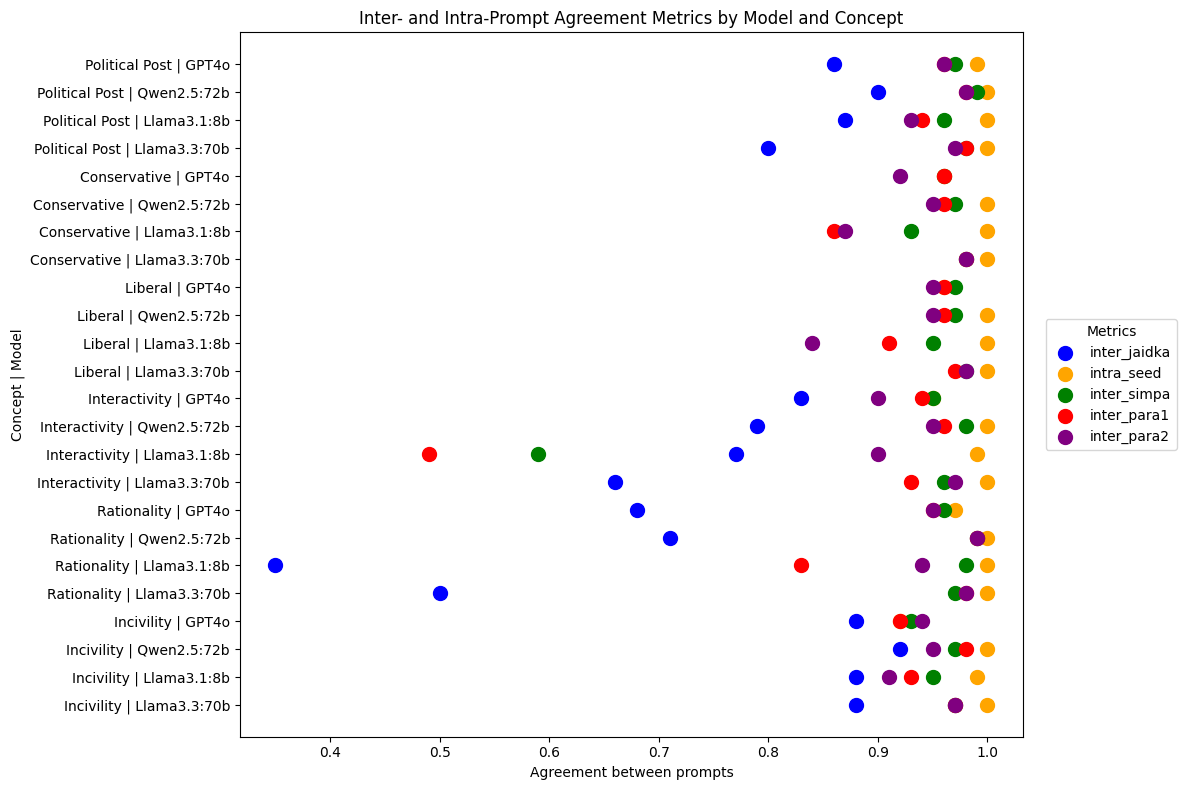

In [42]:
#visualize the results with dots per model and concept per row with different colors of each metric:

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each metric
colors = {
    'inter_jaidka': 'blue',
    'intra_seed': 'orange',
    'inter_simpa': 'green',
    'inter_para1': 'red',
    'inter_para2': 'purple'
}

# Prepare y-tick labels: each row gets a unique label
y_labels = [f"{row['concept']} | {row['model']}" for _, row in zero_agreement_df.iterrows()]
y_pos = range(len(zero_agreement_df))

# Plot each row: accuracy values on x-axis, each row on y-axis
for i, (_, row) in enumerate(zero_agreement_df.iterrows()):
    for metric, color in colors.items():
        if pd.notna(row[metric]):
            ax.scatter(row[metric], i, color=color, s=100, label=metric if i == 0 else "")

# Set y-ticks and labels
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.set_xlabel('Agreement between prompts')
ax.set_ylabel('Concept | Model')
ax.set_title('Inter- and Intra-Prompt Agreement Metrics by Model and Concept')

# Set legend (unique labels only)
handles, labels_ = ax.get_legend_handles_labels()
unique = dict(zip(labels_, handles))
ax.legend(unique.values(), unique.keys(), title='Metrics', loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()


We see that the differences between the annotations of different prompts vary strongly between concepts and models, with low variance for incivility, political post, liberal and conservative, but higher variance for interactivity
and for rationality, but only for the jaidka and boukes prompts
higher variance for interactivity but maily for GPT4o and Llama3.1, the latter shows a strange effect of lower agreement for simpa and para1 than for jaidka, probably due to these prompts yielding more missing annotations

Note some outliers and strange patterns for Llama3.1 -> has some or high number of missing annotations, due to incorrect output formatting per processing pipeline

seed usually has the smallest effect followed by simpa, followed by para1 and para2 (order of para1-2 appear constant per concept across models)
The intra-seed-low shows that temperature has a stronger effect interactivity for Llama-models

for conservative and liberal there is no jaidka, which makes the differences look smaller for the models, but they appear to be on par with interactivity, rationality and incivility

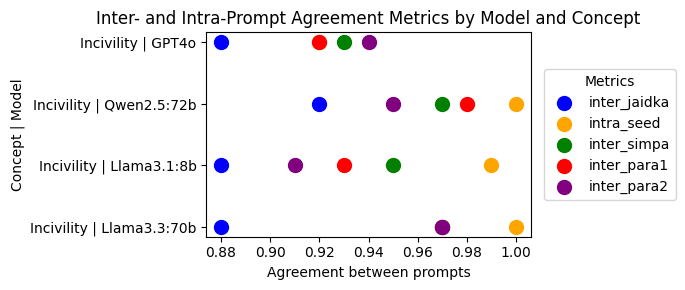

In [55]:
#subset plot for incivility only:
incivility_zero_agreement_df = zero_agreement_df[zero_agreement_df['concept'] == 'Incivility']

#make sure plot is equally spaced, so that the y-axis is not too crowded


# Set up the figure and axis
fig, ax = plt.subplots(figsize=(7, 3))

# Define colors for each metric
colors = {
    'inter_jaidka': 'blue',
    'intra_seed': 'orange',
    'inter_simpa': 'green',
    'inter_para1': 'red',
    'inter_para2': 'purple'
}

# Prepare y-tick labels: each row gets a unique label
y_labels = [f"{row['concept']} | {row['model']}" for _, row in incivility_zero_agreement_df.iterrows()]
y_pos = range(len(incivility_zero_agreement_df))

# Plot each row: accuracy values on x-axis, each row on y-axis
for i, (_, row) in enumerate(incivility_zero_agreement_df.iterrows()):
    for metric, color in colors.items():
        if pd.notna(row[metric]):
            ax.scatter(row[metric], i, color=color, s=100, label=metric if i == 0 else "")

# Set y-ticks and labels
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.set_xlabel('Agreement between prompts')
ax.set_ylabel('Concept | Model')
ax.set_title('Inter- and Intra-Prompt Agreement Metrics by Model and Concept')

# Set legend (unique labels only)
handles, labels_ = ax.get_legend_handles_labels()
unique = dict(zip(labels_, handles))
ax.legend(unique.values(), unique.keys(), title='Metrics', loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
#compare the effect of temperature on the inter- and intra-prompt agreement metrics
concepts = ['Incivility', 'Rationality', 'Interactivity', 'Liberal', 'Conservative', 'Political Post']
models = [ 'Llama3.3:70b', 'Llama3.1:8b']

rows = []

metrics_low = [
    ('inter_jaidka_low', {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                         {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Jaidka'}),
    ('intra_seed_low', {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                    {'temperature':'Low: 0.1', 'seed':'Seed 2', 'run':'Run 1', 'prompt_variant':'Boukes'}),
    ('inter_simpa_low', {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                       {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Simpa1'}),
    ('inter_para1_low', {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                        {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Para1'}),
    ('inter_para2_low', {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                        {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Para2'}),
]

#get low temperature metrics
low_metrics = []
for concept in concepts:
    for model in models:
        row = {'concept': concept, 'model': model}
        for metric, col1_kwargs, col2_kwargs in metrics_low:
            col1 = get_col_by_labels(labelset=col_labels, concept=concept, model=model, **col1_kwargs)
            col2 = get_col_by_labels(labelset=col_labels, concept=concept, model=model, **col2_kwargs)
            acc = compute_accuracy(boukes, col1, col2) if col1 and col2 else None
            row[metric] = round(acc, 2) if acc is not None else None
        low_metrics.append(row)

# Create DataFrame
low_agreement_df = pd.DataFrame(low_metrics)
print(low_agreement_df)

           concept         model  inter_jaidka_low  intra_seed_low  \
0       Incivility  Llama3.3:70b              0.88            0.92   
1       Incivility   Llama3.1:8b              0.89            0.94   
2      Rationality  Llama3.3:70b              0.48            0.99   
3      Rationality   Llama3.1:8b              0.47            0.98   
4    Interactivity  Llama3.3:70b              0.59            0.86   
5    Interactivity   Llama3.1:8b              0.56            0.68   
6          Liberal  Llama3.3:70b               NaN            0.93   
7          Liberal   Llama3.1:8b               NaN            0.93   
8     Conservative  Llama3.3:70b               NaN            0.96   
9     Conservative   Llama3.1:8b               NaN            0.89   
10  Political Post  Llama3.3:70b              0.81            0.83   
11  Political Post   Llama3.1:8b              0.89            0.99   

    inter_simpa_low  inter_para1_low  inter_para2_low  
0              0.90             0

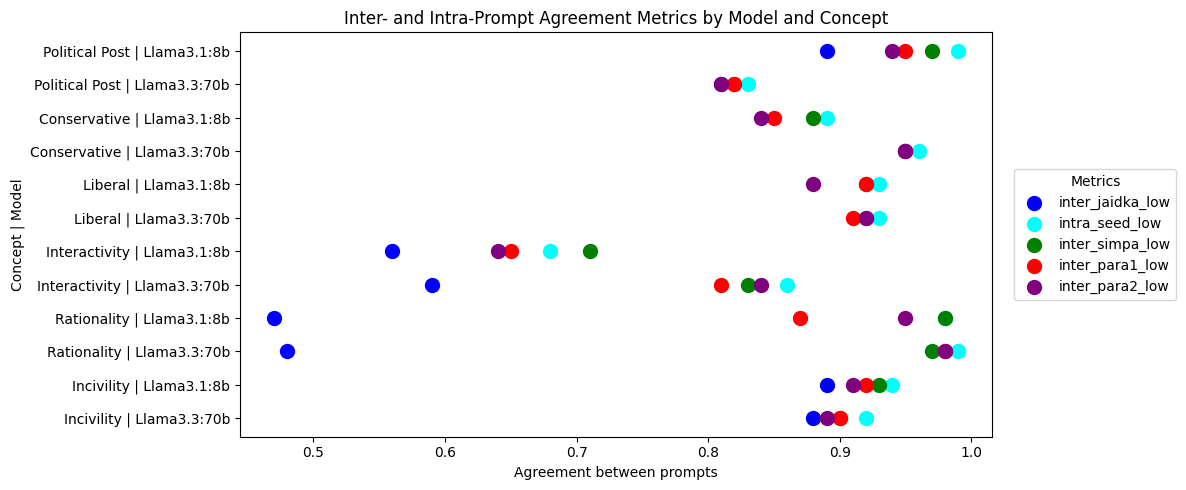

In [51]:
#visualize the results with dots per model and concept per row with different colors of each metric:

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Define colors for each metric
colors = {
    'inter_jaidka_low': 'blue',
    'intra_seed_low': 'cyan',
    'inter_simpa_low': 'green',
    'inter_para1_low': 'red',
    'inter_para2_low': 'purple'
}

# Prepare y-tick labels: each row gets a unique label
y_labels = [f"{row['concept']} | {row['model']}" for _, row in low_agreement_df.iterrows()]
y_pos = range(len(low_agreement_df))

# Plot each row: accuracy values on x-axis, each row on y-axis
for i, (_, row) in enumerate(low_agreement_df.iterrows()):
    for metric, color in colors.items():
        if pd.notna(row[metric]):
            ax.scatter(row[metric], i, color=color, s=100, label=metric if i == 0 else "")

# Set y-ticks and labels
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.set_xlabel('Agreement between prompts')
ax.set_ylabel('Concept | Model')
ax.set_title('Inter- and Intra-Prompt Agreement Metrics by Model and Concept')

# Set legend (unique labels only)
handles, labels_ = ax.get_legend_handles_labels()
unique = dict(zip(labels_, handles))
ax.legend(unique.values(), unique.keys(), title='Metrics', loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
#for L33:70b, the effect of temperature is larger than the changes in prompt for political post and interactivity.
#L31 is also strongly affected by temperature, but was already struggling with zero temperature, probably due to varying amounts of missing annotations per prompt, temperature has a similar effect

In [ ]:
#missing L33_70b: L33_70b_zero_run2; L33_70b_low_run2; L33_70b_zero_seed2_run2;
#missing L31_8b:  L31_8b_zero_seed2_run2; L31_8b_low_run2; 
#missing Q25_72b: Q25_72b_zero_run2; Q25_72b_low_run2; Q25_72b_zero_seed2_run2; Q25_72b_low_seed2_run2;


In [120]:
#Appendix1: Does this influence of model, promptwording and codebook depend on the dataset at hand, compared to Jaidka2024 and MH_clemm2024 data?
#start with Jaidka

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
jaidka_model_columns = [col for col in jaidka.columns if '_dum' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
jaidka_model_columns = [col for col in jaidka_model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col ]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column

#get matching columns in boukes
boukes_model_columns = [col for col in boukes.columns if '_dum' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
boukes_model_columns = [col for col in boukes_model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col ]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column


# Build a mapping from column names to their labels (as dicts)
col_labels_jaidka = {}
col_labels_boukes = {}
col_labels_mhclemm = {}
for col in jaidka_model_columns:
    col_labels_jaidka[col] = get_labels(col)
for col in boukes_model_columns:
    col_labels_boukes[col] = get_labels(col)


## Define metrics and their column selection logic
metrics_zero_externaldf = [
    # concept, metric_name, col1_kwargs, col2_kwargs
    ('inter_jaidka', {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                     {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Jaidka'}),
    ]
concepts = ['Incivility', 'Rationality', 'Interactivity', 'Political Post']
models = [ 'Llama3.3:70b', 'Llama3.1:8b', 'Qwen2.5:72b', 'GPT4o']
datasets = ['Jaidka', 'Boukes']

rows = []
for concept in concepts:
    for model in models:
        for dataset in datasets:
            row = {'concept': concept, 'model': model, 'dataset': dataset}
            print(f"Processing {concept} in {dataset} with model {model}")
            if dataset == 'Jaidka':
                dataset = jaidka
                col_labels = col_labels_jaidka
            elif dataset == 'MHclemm':
                dataset = MHclemm
                col_labels = col_labels_mhclemm
            elif dataset == 'Boukes':
                dataset = boukes
                col_labels = col_labels_boukes
            for metric, col1_kwargs, col2_kwargs in metrics_zero_externaldf:
                col1 = get_col_by_labels(labelset=col_labels, concept=concept, model=model, **col1_kwargs)
                print(f"col1: {col1}")
                col2 = get_col_by_labels(labelset=col_labels, concept=concept, model=model, **col2_kwargs)
                print(f"col2: {col2}")
                acc = compute_accuracy(dataset, col1, col2) if col1 and col2 else None
                row[metric] = round(acc, 2) if acc is not None else None
            rows.append(row)

# Create DataFrame
prompt_agreement_datasets = pd.DataFrame(rows)
print(prompt_agreement_datasets)




Processing Incivility in Jaidka with model Llama3.3:70b
col1: incivility_simple2_L33_70b_zero_dum
col2: incivility_jaidka_L33_70b_zero_dum
Processing Incivility in Boukes with model Llama3.3:70b
col1: incivility_simple2_L33_70b_zero_dum
col2: incivility_jaidka_L33_70b_zero_dum
Processing Incivility in Jaidka with model Llama3.1:8b
col1: incivility_simple2_L31_8b_zero_dum
col2: incivility_jaidka_L31_8b_zero_dum
Processing Incivility in Boukes with model Llama3.1:8b
col1: incivility_simple2_L31_8b_zero_dum
col2: incivility_jaidka_L31_8b_zero_dum
Processing Incivility in Jaidka with model Qwen2.5:72b
col1: incivility_simple2_Q25_72b_zero_dum
col2: incivility_jaidka_Q25_72b_zero_dum
Processing Incivility in Boukes with model Qwen2.5:72b
col1: incivility_simple2_Q25_72b_zero_dum
col2: incivility_jaidka_Q25_72b_zero_dum
Processing Incivility in Jaidka with model GPT4o
col1: incivility_simple2_gpt4o_zero_dum
col2: incivility_jaidka_gpt4o_zero_dum
Processing Incivility in Boukes with model GPT

In [121]:
prompt_agreement_datasets.pivot_table(index=['concept', 'model'], columns='dataset', values='inter_jaidka').round(2)

dataset                      Boukes  Jaidka
concept        model                       
Incivility     GPT4o           0.88    0.92
               Llama3.1:8b     0.91    0.83
               Llama3.3:70b    0.91    0.86
               Qwen2.5:72b     0.93    0.88
Interactivity  GPT4o           0.73    0.28
               Llama3.1:8b     0.82    0.46
               Llama3.3:70b    0.73    0.34
               Qwen2.5:72b     0.83    0.34
Political Post GPT4o           0.89    0.86
               Llama3.1:8b     0.90    0.87
               Llama3.3:70b    0.82    0.84
               Qwen2.5:72b     0.92    0.90
Rationality    GPT4o           0.75    0.72
               Llama3.1:8b     0.47    0.17
               Llama3.3:70b    0.60    0.35
               Qwen2.5:72b     0.77    0.65

In [ ]:
#generally comparable, but usually lower agreement in Jaidka than in Boukes

#however some Jaidka agreement scores are very low, need to check: interactivity (all), Rationality (Llama3.3:70b, Llama3.1:8b), 

In [122]:
#print unique values for interactivity in Jaidka:
# 'interactivity_acknowledgement_simple_L31_8b_zero',
# 'interactivity_acknowledgement_simple_L31_8b_zero_dum',
# 'interactivity_acknowledgement_simple_L33_70b_zero',
# 'interactivity_acknowledgement_simple_L33_70b_zero_dum',
# 'interactivity_acknowledgement_simple_Q25_72b_zero',
# 'interactivity_acknowledgement_simple_Q25_72b_zero_dum',
# 'interactivity_acknowledgement_simple_gpt4o_zero',
# 'interactivity_acknowledgement_simple_gpt4o_zero_dum',

jaidka_interactivity_cols = [col for col in jaidka.columns if 'interactivity' in col and col.endswith('_dum')]
#check the unique values in these columns:
for col in jaidka_interactivity_cols:
    print(f"{col}: {jaidka[col].unique()}")

interactivity_acknowledgement_simple_gpt4o_zero_dum: [1 0]
interactivity_acknowledgement_simple_L33_70b_zero_dum: [0 1]
interactivity_acknowledgement_simple_L31_8b_zero_dum: [0 1]
interactivity_acknowledgement_simple_Q25_72b_zero_dum: [1 0]


In [123]:
jaidka.interactivity_acknowledgement_simple_gpt4o_zero_dum.value_counts()

interactivity_acknowledgement_simple_gpt4o_zero_dum
1    4174
0    1411
Name: count, dtype: int64

In [124]:
jaidka.interactivity_acknowledgement_simple_gpt4o_zero.value_counts()

interactivity_acknowledgement_simple_gpt4o_zero
Yes    4174
No     1411
Name: count, dtype: int64

In [125]:
jaidka.reciprocity_jaidka_gpt4o_zero_dum.value_counts()

reciprocity_jaidka_gpt4o_zero_dum
0    5393
1     192
Name: count, dtype: int64

In [126]:
jaidka.reciprocity_jaidka_gpt4o_zero.value_counts()

reciprocity_jaidka_gpt4o_zero
No     5393
Yes     192
Name: count, dtype: int64

In [ ]:
#appears correct

In [127]:
jaidka.rationality_jaidka_L33_70b_zero.value_counts()

rationality_jaidka_L33_70b_zero
Yes    4325
No     1260
Name: count, dtype: int64

In [128]:
jaidka.rationality_jaidka_L33_70b_zero_dum.value_counts()

rationality_jaidka_L33_70b_zero_dum
1    4325
0    1260
Name: count, dtype: int64

In [129]:
jaidka.rationality_simple2_L33_70b_zero.value_counts()

rationality_simple2_L33_70b_zero
No     4880
Yes     705
Name: count, dtype: int64

In [130]:
jaidka.rationality_simple2_L33_70b_zero_dum.value_counts()

rationality_simple2_L33_70b_zero_dum
0    4880
1     705
Name: count, dtype: int64

In [ ]:
#no indication for errors in dummy-process, rather differences in prevalence of rationality/interactivity for these models between prompts

C:\Users\sstolwi\AppData\Local\Temp\ipykernel_18580\1976887171.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab20', len(concepts)*len(models))


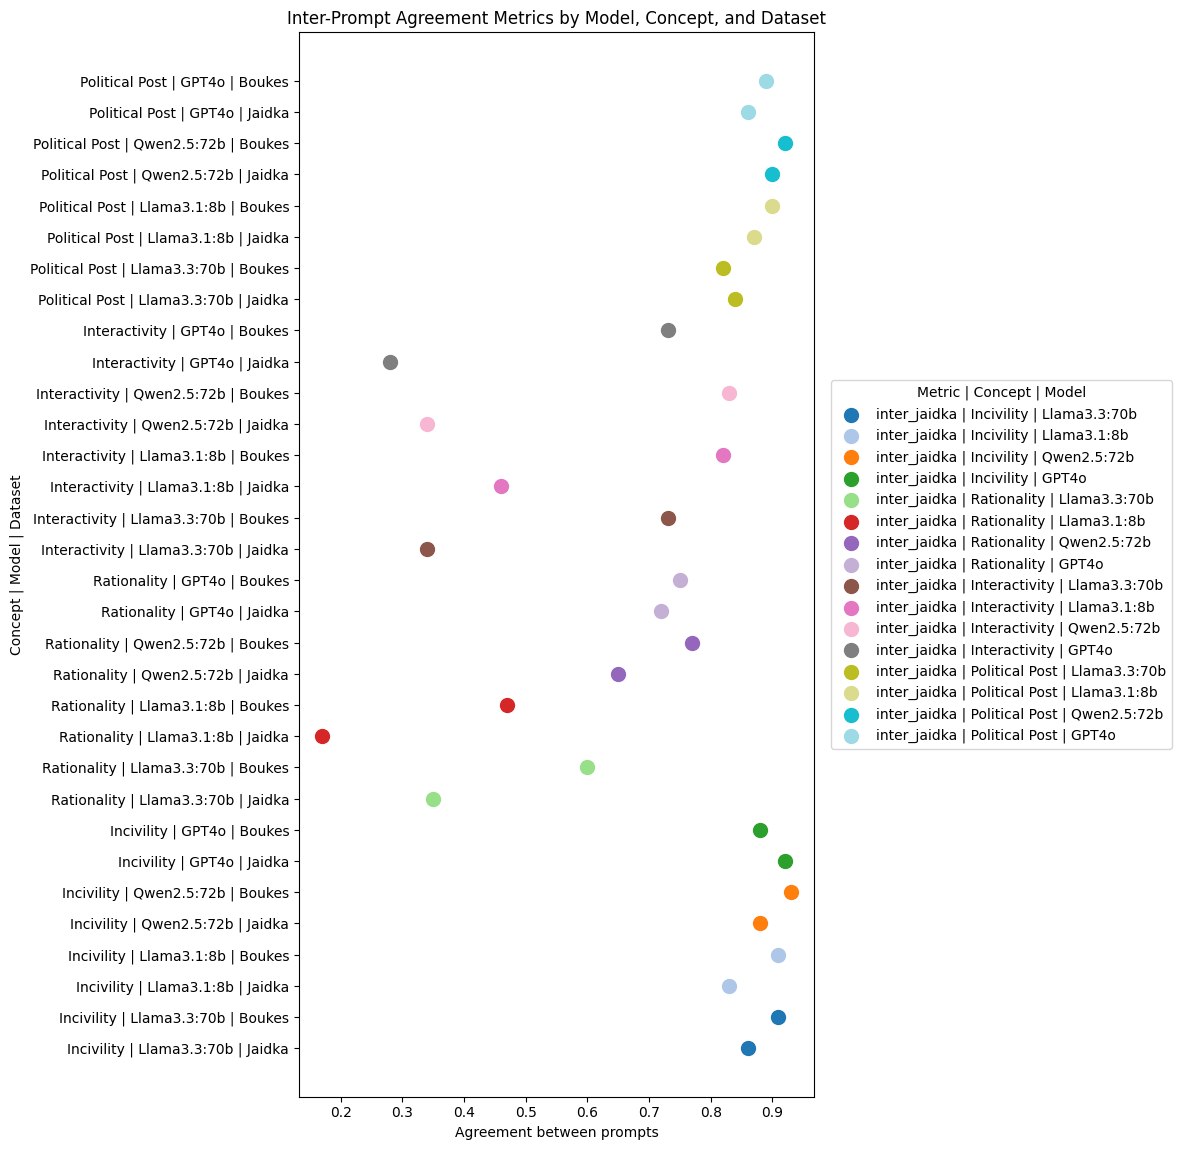

In [ ]:
# Only show non-empty rows (where at least one metric is not null)
non_empty = prompt_agreement_datasets.dropna(subset=['inter_jaidka'], how='all').reset_index(drop=True)

fig_prompt_agreement_datasets, ax = plt.subplots(figsize=(12, len(non_empty)*0.3 + 2))

concepts = non_empty['concept'].unique()
models = non_empty['model'].unique()
color_palette = plt.cm.get_cmap('tab20', len(concepts)*len(models))
concept_model_combos = list(itertools.product(concepts, models))
combo_to_color = {
    (concept, model): color_palette(i)
    for i, (concept, model) in enumerate(concept_model_combos)
}

y_labels = [f"{row['concept']} | {row['model']} | {row['dataset']}" for _, row in non_empty.iterrows()]
y_pos = range(len(non_empty))

# Store handles and labels for legend
legend_handles = {}
for i, (_, row) in enumerate(non_empty.iterrows()):
    combo = (row['concept'], row['model'])
    color = combo_to_color.get(combo, 'black')
    label = f"inter_jaidka | {row['concept']} | {row['model']}"
    for metric in ['inter_jaidka']:
        if pd.notna(row[metric]):
            sc = ax.scatter(row[metric], i, color=color, s=100, label=label)
            # Only add one handle per unique label
            if label not in legend_handles:
                legend_handles[label] = sc

ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.set_xlabel('Agreement between prompts')
ax.set_ylabel('Concept | Model | Dataset')
ax.set_title('Inter-Prompt Agreement Metrics by Model, Concept, and Dataset')

# Show all colors and label them according to metric, concept, and model
ax.legend(
    legend_handles.values(),
    legend_handles.keys(),
    title='Metric | Concept | Model',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()
plt.show()

In [ ]:
#for incivility and political posts, small differences between the codebook-prompt effects between the datasets, but for interactivity and rationality, the differences are larger, with Boukes having higher agreement than Jaidka

In [133]:
#Appendix1: Does this influence of model, promptwording and codebook depend on the dataset at hand, compared to Jaidka2024 and MH_clemm2024 data?
#now for with MHclemm

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
#get matching columns in boukes
boukes_model_columns = [col for col in boukes.columns if '_dum' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
boukes_model_columns = [col for col in boukes_model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col ]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column

#get matching columns in MH_clemm
mh_clemm_model_columns = [col for col in MHclemm.columns if '_dum' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
mh_clemm_model_columns = [col for col in mh_clemm_model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col ]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column

# Build a mapping from column names to their labels (as dicts)
col_labels_boukes = {}
col_labels_mhclemm = {}
for col in boukes_model_columns:
    col_labels_boukes[col] = get_labels(col)
for col in mh_clemm_model_columns:
    col_labels_mhclemm[col] = get_labels(col)


## Define metrics and their column selection logic
metrics_zero_externaldf = [
    # concept, metric_name, col1_kwargs, col2_kwargs
    ('inter_para1', {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                     {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Para1'}),
    ]
concepts = ['Liberal', 'Conservative']
models = [ 'Llama3.3:70b', 'Llama3.1:8b', 'Qwen2.5:72b', 'GPT4o']
datasets = ['MHclemm', 'Boukes']

rows = []
for concept in concepts:
    for model in models:
        for dataset in datasets:
            row = {'concept': concept, 'model': model, 'dataset': dataset}
            if dataset == 'Jaidka':
                dataset = jaidka
                col_labels = col_labels_jaidka
            elif dataset == 'MHclemm':
                dataset = MHclemm
                col_labels = col_labels_mhclemm
            elif dataset == 'Boukes':
                dataset = boukes
                col_labels = col_labels_boukes
            for metric, col1_kwargs, col2_kwargs in metrics_zero_externaldf:
                col1 = get_col_by_labels(labelset=col_labels, concept=concept, model=model, **col1_kwargs)
                col2 = get_col_by_labels(labelset=col_labels, concept=concept, model=model, **col2_kwargs)
                acc = compute_accuracy(dataset, col1, col2) if col1 and col2 else None
                row[metric] = round(acc, 2) if acc is not None else None
            rows.append(row)

# Create DataFrame
prompt_agreement_datasets_ideo = pd.DataFrame(rows)
print(prompt_agreement_datasets_ideo)


         concept         model  dataset  inter_para1
0        Liberal  Llama3.3:70b  MHclemm         0.98
1        Liberal  Llama3.3:70b   Boukes         0.98
2        Liberal   Llama3.1:8b  MHclemm         0.93
3        Liberal   Llama3.1:8b   Boukes         0.93
4        Liberal   Qwen2.5:72b  MHclemm         0.97
5        Liberal   Qwen2.5:72b   Boukes         0.97
6        Liberal         GPT4o  MHclemm         0.96
7        Liberal         GPT4o   Boukes         0.94
8   Conservative  Llama3.3:70b  MHclemm         0.99
9   Conservative  Llama3.3:70b   Boukes         0.99
10  Conservative   Llama3.1:8b  MHclemm         0.95
11  Conservative   Llama3.1:8b   Boukes         0.89
12  Conservative   Qwen2.5:72b  MHclemm         0.98
13  Conservative   Qwen2.5:72b   Boukes         0.97
14  Conservative         GPT4o  MHclemm         0.98
15  Conservative         GPT4o   Boukes         0.94


In [134]:
prompt_agreement_datasets_ideo.pivot_table(index=['concept', 'model'], columns='dataset', values='inter_para1').round(2)

dataset                    Boukes  MHclemm
concept      model                        
Conservative GPT4o           0.94     0.98
             Llama3.1:8b     0.89     0.95
             Llama3.3:70b    0.99     0.99
             Qwen2.5:72b     0.97     0.98
Liberal      GPT4o           0.94     0.96
             Llama3.1:8b     0.93     0.93
             Llama3.3:70b    0.98     0.98
             Qwen2.5:72b     0.97     0.97

C:\Users\sstolwi\AppData\Local\Temp\ipykernel_18580\1770763306.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab20', len(concepts)*len(models))


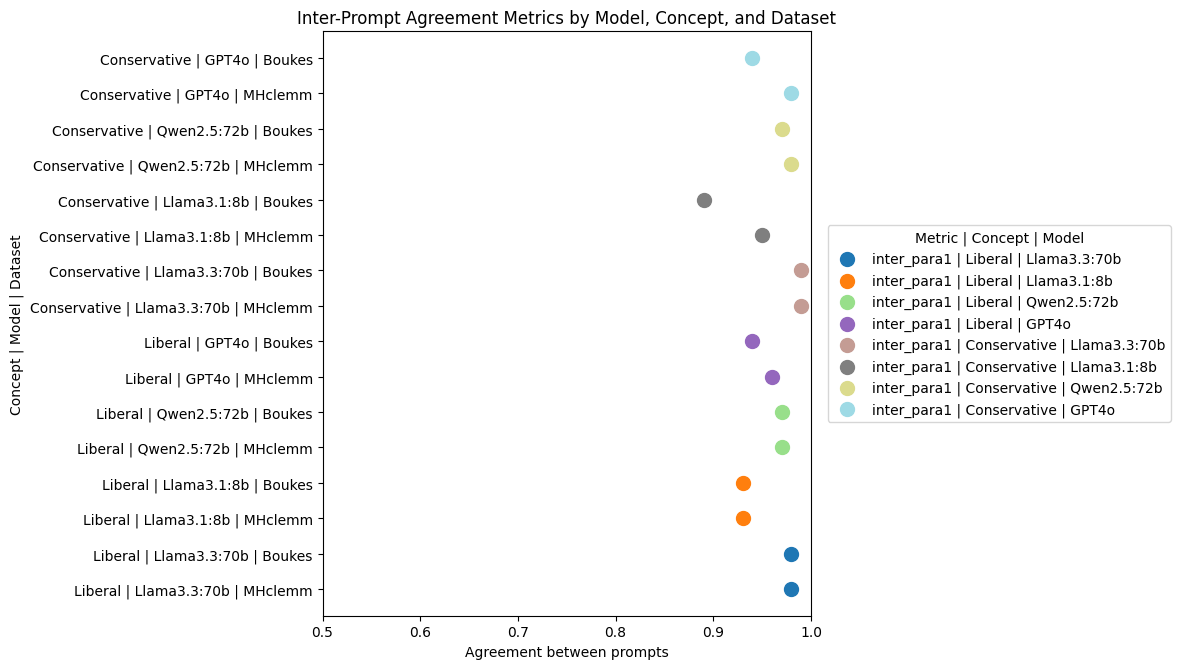

In [138]:
# Only show non-empty rows (where at least one metric is not null)
non_empty = prompt_agreement_datasets_ideo.dropna(subset=['inter_para1'], how='all').reset_index(drop=True)

fig_prompt_agreement_datasets_ideo, ax = plt.subplots(figsize=(12, len(non_empty)*0.3 + 2))

concepts = non_empty['concept'].unique()
models = non_empty['model'].unique()
color_palette = plt.cm.get_cmap('tab20', len(concepts)*len(models))
concept_model_combos = list(itertools.product(concepts, models))
combo_to_color = {
    (concept, model): color_palette(i)
    for i, (concept, model) in enumerate(concept_model_combos)
}

y_labels = [f"{row['concept']} | {row['model']} | {row['dataset']}" for _, row in non_empty.iterrows()]
y_pos = range(len(non_empty))

# Store handles and labels for legend
legend_handles = {}
for i, (_, row) in enumerate(non_empty.iterrows()):
    combo = (row['concept'], row['model'])
    color = combo_to_color.get(combo, 'black')
    label = f"inter_para1 | {row['concept']} | {row['model']}"
    for metric in ['inter_para1']:
        if pd.notna(row[metric]):
            sc = ax.scatter(row[metric], i, color=color, s=100, label=label)
            # Only add one handle per unique label
            if label not in legend_handles:
                legend_handles[label] = sc

ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.set_xlabel('Agreement between prompts')
ax.set_ylabel('Concept | Model | Dataset')
ax.set_title('Inter-Prompt Agreement Metrics by Model, Concept, and Dataset')

# Set x-axis limits to range from 0.5 to 1
ax.set_xlim(0.5, 1)

# Show all colors and label them according to metric, concept, and model
ax.legend(
    legend_handles.values(),
    legend_handles.keys(),
    title='Metric | Concept | Model',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()
plt.show()

In [ ]:
#comparable, but overall better agreement for all concepts/models in MHClemm compared to Boukes

In [168]:
#how well do the models perform om Jaidka and MHclemm data versus manual annotations?
#in terms of F1, accuracy and missing annotations
#start with Jaidka

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in jaidka.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

# Initialize a dictionary to store macro F1 scores
macro_f1_scores = {}
accuracy_scores = {}
name = {}
model = {}
# Calculate macro F1 scores for each model column
for model_col in model_columns:
    if 'incivility' in model_col:
        try:
            subset = jaidka.loc[:, ['Uncivil_abuse', model_col]].dropna()
            macro_f1 = get_macro_f1_score(subset, model_col, 'Uncivil_abuse')
            accuracy = (subset[model_col] == subset['Uncivil_abuse']).mean()
            observations = subset[model_col].notna().sum()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            name[model_col] = 'Incivility'
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'rationality' in model_col:
        try:
            subset = jaidka.loc[:, ['Justification', model_col]].dropna()
            macro_f1 = get_macro_f1_score(subset, model_col, 'Justification')
            accuracy = (subset[model_col] == subset['Justification']).mean()
            observations = subset[model_col].notna().sum()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            name[model_col] = 'Rationality'
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'interactivity' in model_col or 'reciprocity' in model_col:
        try:
            subset = jaidka.loc[:, ['Reciprocity', model_col]].dropna()
            macro_f1 = get_macro_f1_score(subset, model_col, 'Reciprocity')
            accuracy = (subset[model_col] == subset['Reciprocity']).mean()
            observations = subset[model_col].notna().sum()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            name[model_col] = 'Interactivity'
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'political_post' in model_col:
        try:
            subset = jaidka.loc[:, ['Relevance', model_col]].dropna()
            macro_f1 = get_macro_f1_score(subset, model_col, 'Relevance')
            accuracy = (subset[model_col] == subset['Relevance']).mean()
            observations = subset[model_col].notna().sum()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            name[model_col] = 'Political Post'      
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'gpt4o' in model_col:
            model[model_col] = 'gpt4o'
    if 'gpt4T' in model_col:
            model[model_col] = 'gpt4T'
    if 'L33_70b' in model_col:
            model[model_col] = 'Llama3.3:70b'
    if 'L31_8b' in model_col:
            model[model_col] = 'Llama3.1:8b'
    if 'Q25_72b' in model_col:
            model[model_col] = 'Qwen2.5:72b'
        


# Convert the macro F1 scores and accuracy scores to a DataFrame for better visualization
scores_df = pd.DataFrame({
    'Label': list(macro_f1_scores.keys()),
    'Concept': [name[model_col] for model_col in macro_f1_scores.keys()],
    'Model': [model[model_col] for model_col in macro_f1_scores.keys()],
    'Macro F1 Score': list(macro_f1_scores.values()),
    'Accuracy': [accuracy_scores[model] for model in macro_f1_scores.keys()],
    'Observations': [jaidka[model_col].notna().sum() for model_col in macro_f1_scores.keys()],
    'Codebook': ['Jaidka' if 'jaidka' in model_col else 'Boukes' for model_col in macro_f1_scores.keys()]  
})

# Sort the DataFrame by Macro F1 Score in descending order
scores_df = scores_df.sort_values(by=['Concept', 'Model'], ascending=False)

# Round the scores to 2 decimal places
scores_df['Macro F1 Score'] = scores_df['Macro F1 Score'].round(2)
scores_df['Accuracy'] = scores_df['Accuracy'].round(2)

# Display the scores
print("Macro F1 Scores and Accuracy for jaidka Data:")
print(scores_df)


Macro F1 Scores and Accuracy for jaidka Data:
                                                         Label  \
2                     rationality_jaidka_gpt4o_system_zero_dum   
9                    rationality_simple2_gpt4o_system_zero_dum   
30                         rationality_jaidka_Q25_72b_zero_dum   
31                        rationality_simple2_Q25_72b_zero_dum   
16                         rationality_jaidka_L33_70b_zero_dum   
17                        rationality_simple2_L33_70b_zero_dum   
0                          rationality_simple2_L31_8b_zero_dum   
1                           rationality_jaidka_L31_8b_zero_dum   
5                  political_post_jaidka_gpt4o_system_zero_dum   
8                         political_post_gpt4o_system_zero_dum   
28                             political_post_Q25_72b_zero_dum   
29                      political_post_jaidka_Q25_72b_zero_dum   
14                             political_post_L33_70b_zero_dum   
15                      politi

In [169]:
#pivot table for better visualization
#showing the F1 and accuracy for each codebook side by side
pivot_df = scores_df.pivot_table(index=['Concept', 'Model'], columns='Codebook', values=['Macro F1 Score', 'Accuracy', 'Observations'])
pivot_df = pivot_df.round(2)
print("Pivot Table of Macro F1 Scores and Accuracy for Jaidka Data:")
print(pivot_df)

Pivot Table of Macro F1 Scores and Accuracy for Jaidka Data:
                            Accuracy        Macro F1 Score         \
Codebook                      Boukes Jaidka         Boukes Jaidka   
Concept        Model                                                
Incivility     Llama3.1:8b      0.69   0.76           0.60   0.64   
               Llama3.3:70b     0.48   0.60           0.45   0.53   
               Qwen2.5:72b      0.46   0.55           0.43   0.50   
               gpt4o            0.82   0.82           0.70   0.69   
Interactivity  Llama3.1:8b      0.49   0.70           0.48   0.55   
               Llama3.3:70b     0.47   0.69           0.47   0.51   
               Qwen2.5:72b      0.47   0.69           0.47   0.52   
               gpt4o            0.44   0.69           0.44   0.49   
Political Post Llama3.1:8b      0.84   0.89           0.66   0.66   
               Llama3.3:70b     0.87   0.93           0.69   0.57   
               Qwen2.5:72b      0.84   0.8

In [ ]:
#generally (much) poorer performance of models on Jaidka data compared to Boukes data, with lower F1 and accuracy scores, but here Jaidka prompts do perform better, showing the relevance of the codebook differences to prompt based annotations

In [179]:
#how well do the models perform om Jaidka and MHclemm data versus manual annotations?
#in terms of F1, accuracy and missing annotations

#now for MHclemm:

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in MHclemm.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns = [col for col in model_columns if 'para2' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

# Initialize a dictionary to store macro F1 scores
macro_f1_scores = {}
accuracy_scores = {}
name = {}
model = {}
# Calculate macro F1 scores for each model column
for model_col in model_columns:
    if '_lib' in model_col:
        try:
            macro_f1 = get_macro_f1_score(MHclemm, model_col, 'label_lib_dum')
            accuracy = (MHclemm[model_col] == MHclemm['label_lib_dum']).mean()
            observations = MHclemm[model_col].notna().sum()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy     
            name[model_col] = 'Liberal'   
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if '_con' in model_col:
        try:
            macro_f1 = get_macro_f1_score(MHclemm, model_col, 'label_con_dum')
            accuracy = (MHclemm[model_col] == MHclemm['label_con_dum']).mean()
            observations = MHclemm[model_col].notna().sum()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy  
            name[model_col] = 'Conservative'      
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'gpt4o' in model_col:
            model[model_col] = 'gpt4o'
    if 'gpt4T' in model_col:
            model[model_col] = 'gpt4T'
    if 'L33_70b' in model_col:
            model[model_col] = 'Llama3.3:70b'
    if 'L31_8b' in model_col:
            model[model_col] = 'Llama3.1:8b'
    if 'Q25_72b' in model_col:
            model[model_col] = 'Qwen2.5:72b'
        
#subset = jaidka.loc[:, ['Relevance', model_col]].dropna()
#            macro_f1 = get_macro_f1_score(subset, model_col, 'Relevance')
#            accuracy = (subset[model_col] == subset['Relevance']).mean()
#            observations = subset[model_col].notna().sum()
#            macro_f1_scores[model_col] = macro_f1
#            accuracy_scores[model_col] = accuracy
#            name[model_col] = 'Political Post'  

# Convert the macro F1 scores and accuracy scores to a DataFrame for better visualization
scores_df = pd.DataFrame({
    'Label': list(macro_f1_scores.keys()),
    'Concept': [name[model_col] for model_col in macro_f1_scores.keys()],
    'Model': [model[model_col] for model_col in macro_f1_scores.keys()],
    'Macro F1 Score': list(macro_f1_scores.values()),
    'Accuracy': [accuracy_scores[model] for model in macro_f1_scores.keys()],
    'Observations': [MHclemm[model_col].notna().sum() for model_col in macro_f1_scores.keys()],
    'Codebook': ['Para1' if 'para1' in model_col else 'Boukes' for model_col in macro_f1_scores.keys()]  
})

# Sort the DataFrame by Macro F1 Score in descending order
scores_df = scores_df.sort_values(by=['Concept', 'Model'], ascending=False)

# Round the scores to 2 decimal places
scores_df['Macro F1 Score'] = scores_df['Macro F1 Score'].round(2)
scores_df['Accuracy'] = scores_df['Accuracy'].round(2)

# Display the scores
print("Macro F1 Scores and Accuracy for jaidka Data:")
print(scores_df)

#pivot table for better visualization
#showing the F1 and accuracy for each codebook side by side
pivot_df = scores_df.pivot_table(index=['Concept', 'Model'], columns='Codebook', values=['Macro F1 Score', 'Accuracy', 'Observations'])
pivot_df = pivot_df.round(2)
print("Pivot Table of Macro F1 Scores and Accuracy for MHclemm Data:")
print(pivot_df)



Macro F1 Scores and Accuracy for jaidka Data:
                                                    Label       Concept  \
13        political_ideology_US_gpt4o_system_zero_lib_dum       Liberal   
15  political_ideology_US_para1_gpt4o_system_zero_lib_dum       Liberal   
9              political_ideology_US_Q25_72b_zero_lib_dum       Liberal   
11       political_ideology_US_para1_Q25_72b_zero_lib_dum       Liberal   
1              political_ideology_US_L33_70b_zero_lib_dum       Liberal   
3        political_ideology_US_para1_L33_70b_zero_lib_dum       Liberal   
5               political_ideology_US_L31_8b_zero_lib_dum       Liberal   
7         political_ideology_US_para1_L31_8b_zero_lib_dum       Liberal   
12        political_ideology_US_gpt4o_system_zero_con_dum  Conservative   
14  political_ideology_US_para1_gpt4o_system_zero_con_dum  Conservative   
8              political_ideology_US_Q25_72b_zero_con_dum  Conservative   
10       political_ideology_US_para1_Q25_72b_zero_con_

In [ ]:
#both boukes and para1 have decent performance on MHclemm data both sometimes better than the other

In [ ]:
#RQ4: What is the overlap in the concepts measured by the different models on Boukes2024 data, with Boukes prompts, zero temperature?

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

#create a table with each model and concept in rows and columns and the percentage of identical annotations as value
# Initialize a dictionary to store the overlap percentages
overlap_percentages = {}   
# Calculate overlap percentages for each model column
for model_col in model_columns:
    concept = get_labels(model_col).get('concept', 'Unknown')
    model = get_labels(model_col).get('model', 'Unknown')
    
    # Calculate the percentage of identical annotations for each concept
    for other_model_col in model_columns:
        if model_col != other_model_col:
            other_concept = get_labels(other_model_col).get('concept', 'Unknown')
            other_model = get_labels(other_model_col).get('model', 'Unknown')
            # Only compare if the concept is the same
            if concept == other_concept:
                overlap_count = (boukes[model_col] == boukes[other_model_col]).sum()
                total_count = boukes[model_col].notna().sum()
                if total_count > 0:
                    overlap_percentage = (overlap_count / total_count) * 100
                    overlap_percentages[(concept, model, other_model)] = round(overlap_percentage, 1)

# Convert the overlap percentages to a DataFrame for better visualization
overlap_df = pd.DataFrame([
    {'Concept': k[0], 'Model 1': k[1], 'Model 2': k[2], 'Overlap %': v}
    for k, v in overlap_percentages.items()
])
print(overlap_df)

# for better visualization, for each concept pivot the DataFrame, with models as columns and overlap percentages as values
def print_lower_triangle(pivot_df, concept_name):
    # Mask upper triangle
    mask = np.triu(np.ones(pivot_df.shape), k=1).astype(bool)
    lower_triangle = pivot_df.mask(mask)
    print(f"Overlap percentages for {concept_name} concept:")
    print(lower_triangle)

pivot_conservative = overlap_df[overlap_df['Concept'] == 'Conservative'].pivot(index='Model 1', columns='Model 2', values='Overlap %')
print_lower_triangle(pivot_conservative, "Conservative")

pivot_liberal = overlap_df[overlap_df['Concept'] == 'Liberal'].pivot(index='Model 1', columns='Model 2', values='Overlap %')
print_lower_triangle(pivot_liberal, "Liberal")

pivot_interactivity = overlap_df[overlap_df['Concept'] == 'Interactivity'].pivot(index='Model 1', columns='Model 2', values='Overlap %')
print_lower_triangle(pivot_interactivity, "Interactivity")

pivot_rationality = overlap_df[overlap_df['Concept'] == 'Rationality'].pivot(index='Model 1', columns='Model 2', values='Overlap %')
print_lower_triangle(pivot_rationality, "Rationality")

pivot_incivility = overlap_df[overlap_df['Concept'] == 'Incivility'].pivot(index='Model 1', columns='Model 2', values='Overlap %')
print_lower_triangle(pivot_incivility, "Incivility")

pivot_political = overlap_df[overlap_df['Concept'] == 'Political Post'].pivot(index='Model 1', columns='Model 2', values='Overlap %')
print_lower_triangle(pivot_political, "Political Post")
                         

            Concept Model 1       Model 2  Overlap %
0        Incivility   GPT4o         GPT4T       89.9
1        Incivility   GPT4o   Qwen2.5:72b       74.6
2        Incivility   GPT4o  Llama3.3:70b       73.9
3        Incivility   GPT4o   Llama3.1:8b       85.9
4       Rationality   GPT4o         GPT4T       98.0
..              ...     ...           ...        ...
115  Political Post   GPT4o         GPT4T       93.1
116  Political Post   GPT4T   Qwen2.5:72b       92.2
117  Political Post   GPT4T  Llama3.3:70b       87.9
118  Political Post   GPT4T   Llama3.1:8b       91.0
119  Political Post   GPT4T         GPT4o       93.1

[120 rows x 4 columns]
Overlap percentages for Conservative concept (lower triangle):
Model 2       GPT4T  GPT4o  Llama3.1:8b  Llama3.3:70b  Qwen2.5:72b
Model 1                                                           
GPT4T           NaN    NaN          NaN           NaN          NaN
GPT4o          94.1    NaN          NaN           NaN          NaN
Llama3.1:

In [ ]:
#pretty high overlap overall, with some lower values for incivility and interactivity 

In [200]:
overlap_df.sort_values(by=['Overlap %'])

,Concept,Model 1,Model 2,Overlap %
11,Interactivity,GPT4o,Llama3.1:8b,66.3
84,Interactivity,Llama3.1:8b,GPT4o,66.3
85,Interactivity,Llama3.1:8b,GPT4T,68.2
19,Interactivity,GPT4T,Llama3.1:8b,68.2
10,Interactivity,GPT4o,Llama3.3:70b,70.5
...,...,...,...,...
60,Rationality,Qwen2.5:72b,GPT4o,97.3
61,Rationality,Qwen2.5:72b,GPT4T,97.4
13,Rationality,GPT4T,Qwen2.5:72b,97.4
12,Rationality,GPT4T,GPT4o,98.0


In [201]:
#now look closer, what about the overlap in positive annotations, i.e. the percentage of positive annotations that are identical between models for each concept?

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

#create a table with each model and concept in rows and columns and the percentage of identical annotations as value
# Initialize a dictionary to store the overlap percentages
overlap_percentages = {}   
# Calculate overlap percentages for each model column
for model_col in model_columns:
    concept = get_labels(model_col).get('concept', 'Unknown')
    model = get_labels(model_col).get('model', 'Unknown')
    
    # Calculate the percentage of identical annotations for each concept
    for other_model_col in model_columns:
        if model_col != other_model_col:
            other_concept = get_labels(other_model_col).get('concept', 'Unknown')
            other_model = get_labels(other_model_col).get('model', 'Unknown')
            # Only compare if the concept is the same
            if concept == other_concept:
                # Only consider overlap where both models predict positive (i.e., value == 1)
                both_positive = (boukes[model_col] == 1) & (boukes[other_model_col] == 1)
                overlap_count = both_positive.sum()
                # Total number of positive annotations in model_col (denominator)
                total_positive = (boukes[model_col] == 1).sum()
                if total_positive > 0:
                    overlap_percentage = (overlap_count / total_positive) * 100
                    overlap_percentages[(concept, model, other_model)] = round(overlap_percentage, 1)


# Convert the overlap percentages to a DataFrame for better visualization
positive_overlap_df = pd.DataFrame([
    {'Concept': k[0], 'Model 1': k[1], 'Model 2': k[2], 'Positive Overlap %': v}
    for k, v in overlap_percentages.items()
])
print(positive_overlap_df)

# for better visualization, for each concept pivot the DataFrame, with models as columns and overlap percentages as values
def print_lower_triangle(pivot_df, concept_name):
    # Mask upper triangle
    mask = np.triu(np.ones(pivot_df.shape), k=1).astype(bool)
    lower_triangle = pivot_df.mask(mask)
    print(f"Overlap percentages for {concept_name} concept:")
    print(lower_triangle)

pivot_conservative = positive_overlap_df[positive_overlap_df['Concept'] == 'Conservative'].pivot(index='Model 1', columns='Model 2', values='Positive Overlap %')
print_lower_triangle(pivot_conservative, "Conservative")

pivot_liberal = positive_overlap_df[positive_overlap_df['Concept'] == 'Liberal'].pivot(index='Model 1', columns='Model 2', values='Positive Overlap %')
print_lower_triangle(pivot_liberal, "Liberal")

pivot_interactivity = positive_overlap_df[positive_overlap_df['Concept'] == 'Interactivity'].pivot(index='Model 1', columns='Model 2', values='Positive Overlap %')
print_lower_triangle(pivot_interactivity, "Interactivity")

pivot_rationality = positive_overlap_df[positive_overlap_df['Concept'] == 'Rationality'].pivot(index='Model 1', columns='Model 2', values='Positive Overlap %')
print_lower_triangle(pivot_rationality, "Rationality")

pivot_incivility = positive_overlap_df[positive_overlap_df['Concept'] == 'Incivility'].pivot(index='Model 1', columns='Model 2', values='Positive Overlap %')
print_lower_triangle(pivot_incivility, "Incivility")

pivot_political = positive_overlap_df[positive_overlap_df['Concept'] == 'Political Post'].pivot(index='Model 1', columns='Model 2', values='Positive Overlap %')
print_lower_triangle(pivot_political, "Political Post")
                         

            Concept Model 1       Model 2  Positive Overlap %
0        Incivility   GPT4o         GPT4T                95.9
1        Incivility   GPT4o   Qwen2.5:72b                92.0
2        Incivility   GPT4o  Llama3.3:70b                91.7
3        Incivility   GPT4o   Llama3.1:8b                67.7
4       Rationality   GPT4o         GPT4T                62.9
..              ...     ...           ...                 ...
115  Political Post   GPT4o         GPT4T                98.8
116  Political Post   GPT4T   Qwen2.5:72b                99.3
117  Political Post   GPT4T  Llama3.3:70b                99.7
118  Political Post   GPT4T   Llama3.1:8b                94.9
119  Political Post   GPT4T         GPT4o                85.0

[120 rows x 4 columns]
Overlap percentages for Conservative concept:
Model 2       GPT4T  GPT4o  Llama3.1:8b  Llama3.3:70b  Qwen2.5:72b
Model 1                                                           
GPT4T           NaN    NaN          NaN           Na

In [ ]:
#now the variance between models in overlap is much larger

In [20]:
#find out for each concept:
#   -what is the percentage of identical annotations between models (positive and negative) that agree with the manual annotations
#   -what is the percentage of annotations for three of the four models have correct annotations
#   -what is the percentage of annotations for two of the four models have correct annotations
#   -what is the percentage of annotations for which only one model has correct annotations 
#   -what is the percentage of identical annotations between models (positive and negative) that do not agree with the manual annotations


# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

# Define concepts and their ground truth columns
concepts_info = [
    ('Incivility', 'INCIVILITY_DUMMY'),
    ('Rationality', 'RATIONALITY_DUMMY'),
    ('Interactivity', 'INTERACTIVITY_DUMMY'),
    ('Liberal', 'LIBERAL_DUMMY'),
    ('Conservative', 'CONSERVATIVE_DUMMY'),
    ('Political Post', 'TopicRelevance')
]

dataset = boukes  # Use the Boukes dataset for this analysis
percentages_rows = []

for concept, gt_col in concepts_info:
    # Filter model columns for this concept
    concept_model_cols = [col for col in model_columns if get_labels(col)['concept'] == concept]
    if not concept_model_cols or gt_col not in dataset.columns:
        continue

    # Calculate agreement counts
    agree_counts = (dataset[concept_model_cols].values == dataset[gt_col].values[:, None]).sum(axis=1)
    total_count = dataset[gt_col].notna().sum()

    identical_agree = ((agree_counts == len(concept_model_cols)) & dataset[gt_col].notna().values).sum()
    identical_disagree = ((agree_counts == 0) & dataset[gt_col].notna().values).sum()
    three_agree = ((agree_counts == 3) & dataset[gt_col].notna().values).sum()
    two_agree = ((agree_counts == 2) & dataset[gt_col].notna().values).sum()
    one_agree = ((agree_counts == 1) & dataset[gt_col].notna().values).sum()

    percentages_rows.append({
        'Concept': concept,
        'Identical Agree %': round(identical_agree / total_count * 100, 1),
        'Three Agree %': round(three_agree / total_count * 100, 1),
        'Two Agree %': round(two_agree / total_count * 100, 1),
        'One Agrees %': round(one_agree / total_count * 100, 1),
        'Identical Disagree %': round(identical_disagree / total_count * 100, 1)
    })

percentages_df = pd.DataFrame(percentages_rows)
print("Percentages for all Concepts:")
print(percentages_df)






Percentages for all Concepts:
          Concept  Identical Agree %  Three Agree %  Two Agree %  \
0      Incivility               52.5           11.7         10.1   
1     Rationality               77.7            2.0          1.8   
2   Interactivity               48.0           16.1          4.4   
3         Liberal               69.7            4.3          5.7   
4    Conservative               70.1            5.0          4.2   
5  Political Post               60.6            5.2          4.0   

   One Agrees %  Identical Disagree %  
0           5.7                   8.4  
1           3.0                  10.8  
2           6.0                   6.3  
3           3.5                   6.7  
4           3.2                   4.9  
5           4.1                  17.5  


In [22]:
#now repeat for positive annotations only, i.e. the percentage of positive human annotations that are identical between models for each concept


# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

# Define concepts and their ground truth columns
concepts_info = [
    ('Incivility', 'INCIVILITY_DUMMY'),
    ('Rationality', 'RATIONALITY_DUMMY'),
    ('Interactivity', 'INTERACTIVITY_DUMMY'),
    ('Liberal', 'LIBERAL_DUMMY'),
    ('Conservative', 'CONSERVATIVE_DUMMY'),
    ('Political Post', 'TopicRelevance')
]

percentages_rows = []

for concept, gt_col in concepts_info:
    dataset = boukes.where(boukes[gt_col] == 1)
    # Filter model columns for this concept
    concept_model_cols = [col for col in model_columns if get_labels(col)['concept'] == concept]
    if not concept_model_cols or gt_col not in dataset.columns:
        continue

    # Calculate agreement counts
    agree_counts = (dataset[concept_model_cols].values == dataset[gt_col].values[:, None]).sum(axis=1)
    total_count = dataset[gt_col].notna().sum()

    identical_agree = ((agree_counts == len(concept_model_cols)) & dataset[gt_col].notna().values).sum()
    identical_disagree = ((agree_counts == 0) & dataset[gt_col].notna().values).sum()
    three_agree = ((agree_counts == 3) & dataset[gt_col].notna().values).sum()
    two_agree = ((agree_counts == 2) & dataset[gt_col].notna().values).sum()
    one_agree = ((agree_counts == 1) & dataset[gt_col].notna().values).sum()

    percentages_rows.append({
        'Concept': concept,
        'Identical Agree %': round(identical_agree / total_count * 100, 1),
        'Three Agree %': round(three_agree / total_count * 100, 1),
        'Two Agree %': round(two_agree / total_count * 100, 1),
        'One Agrees %': round(one_agree / total_count * 100, 1),
        'Identical Disagree %': round(identical_disagree / total_count * 100, 1)
    })

percentages_df = pd.DataFrame(percentages_rows)
print("Percentages for all Concepts:")
print(percentages_df)






Percentages for all Concepts:
          Concept  Identical Agree %  Three Agree %  Two Agree %  \
0      Incivility               40.4           10.2         15.1   
1     Rationality                8.9            5.9          7.3   
2   Interactivity               17.0            8.8         12.0   
3         Liberal               36.2            6.5         15.5   
4    Conservative               40.9            5.8         11.8   
5  Political Post               55.4            4.5          3.5   

   One Agrees %  Identical Disagree %  
0           7.1                  13.5  
1          14.8                  58.1  
2          16.5                  21.9  
3           7.7                  20.4  
4           8.1                  16.8  
5           3.3                  25.7  


In [ ]:

for concept, gt_col in concepts_info:
    concept_name = concept
    # Filter model columns for this concept
    concept_model_cols = [col for col in model_columns_allprompts if get_labels(col)['concept'] == concept_name]
    if not concept_model_cols or gt_col not in boukes.columns:
        continue

    # Calculate agreement matrix: shape (n_comments, n_models)
    agree_matrix = (boukes[concept_model_cols].values == boukes[gt_col].values[:, None])
    agree_counts = agree_matrix.sum(axis=1)  # total number of models agreeing per comment

    # Count number of comments for each possible number of models agreeing
    max_agree = len(concept_model_cols)
    x_vals = np.arange(0, max_agree + 1)
    comment_counts = np.array([(agree_counts == n).sum() for n in x_vals])

    # Plot line chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x_vals, comment_counts, marker='o', color='blue', label='All Models')

    ax.set_xticks(x_vals)
    ax.set_xlabel('Number of Models Agreeing with Human Annotation')
    ax.set_ylabel('Number of Comments')
    ax.set_title(f'Agreement Distribution for {concept_name}')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Comprehensive Agreement Analysis: Model vs Human Annotations

This section analyzes the agreement patterns between different models and human annotations across all concepts.

In [76]:
# Function to calculate agreement counts for each model vs human annotations
def calculate_agreement_stats(df, model_cols, gt_col):
    """
    Calculate agreement statistics between each model and ground truth
    Returns a dictionary with model names and their agreement counts
    """
    agreement_stats = {}
    
    for model_col in model_cols:
        # Skip if column doesn't exist
        if model_col not in df.columns or gt_col not in df.columns:
            continue
            
        # Get valid (non-null) observations for both columns
        valid_mask = df[model_col].notna() & df[gt_col].notna()
        if valid_mask.sum() == 0:
            continue
            
        model_pred = df.loc[valid_mask, model_col]
        human_truth = df.loc[valid_mask, gt_col]
        
        # Calculate agreements and disagreements
        agreements = (model_pred == human_truth).sum()
        disagreements = (model_pred != human_truth).sum()
        total = len(model_pred)
        
        # Get model info using the existing get_labels function
        model_info = get_labels(model_col)
        model_name = model_info['model']
        
        agreement_stats[model_col] = {
            'model_name': model_name,
            'agreements': agreements,
            'disagreements': disagreements,
            'total': total,
            'agreement_rate': agreements / total if total > 0 else 0
        }
    
    return agreement_stats

# Calculate agreement statistics for all concepts
all_agreement_stats = {}

# Use the same model selection as before
model_columns_for_analysis = model_columns_allprompts

# Define concepts and their ground truth columns
concepts_info_analysis = [
    ('Incivility', 'INCIVILITY_DUMMY'),
    ('Rationality', 'RATIONALITY_DUMMY'),
    ('Interactivity', 'INTERACTIVITY_DUMMY'),
    ('Liberal', 'LIBERAL_DUMMY'),
    ('Conservative', 'CONSERVATIVE_DUMMY'),
    ('Political Post', 'TopicRelevance')
]

for concept_name, gt_col in concepts_info_analysis:
    # Filter model columns for this concept
    concept_model_cols = [col for col in model_columns_for_analysis if get_labels(col)['concept'] == concept_name]
    
    if concept_model_cols and gt_col in boukes.columns:
        stats = calculate_agreement_stats(boukes, concept_model_cols, gt_col)
        all_agreement_stats[concept_name] = stats
        
        print(f"\n=== {concept_name} Agreement Statistics ===")
        for model_col, stat in stats.items():
            print(f"{stat['model_name']}: {stat['agreements']}/{stat['total']} agreements ({stat['agreement_rate']:.3f})")

print(f"\nProcessed {len(all_agreement_stats)} concepts")


=== Incivility Agreement Statistics ===
GPT4o: 2873/3862 agreements (0.744)
Qwen2.5:72b: 2833/3862 agreements (0.734)
Qwen2.5:72b: 2869/3862 agreements (0.743)
Qwen2.5:72b: 2810/3862 agreements (0.728)
Qwen2.5:72b: 2790/3862 agreements (0.722)
Qwen2.5:72b: 2824/3862 agreements (0.731)
Llama3.3:70b: 2844/3862 agreements (0.736)
Llama3.1:8b: 2709/3862 agreements (0.701)
GPT4o: 2707/3862 agreements (0.701)
GPT4o: 2768/3862 agreements (0.717)
GPT4o: 2837/3862 agreements (0.735)
GPT4o: 2800/3862 agreements (0.725)
Llama3.1:8b: 2689/3862 agreements (0.696)
Llama3.1:8b: 2672/3862 agreements (0.692)
Llama3.1:8b: 2766/3862 agreements (0.716)
Llama3.1:8b: 2748/3862 agreements (0.712)
Llama3.3:70b: 2818/3862 agreements (0.730)
Llama3.3:70b: 2861/3862 agreements (0.741)
Llama3.3:70b: 2848/3862 agreements (0.737)
Llama3.3:70b: 2866/3862 agreements (0.742)

=== Rationality Agreement Statistics ===
GPT4o: 3256/3862 agreements (0.843)
Qwen2.5:72b: 3265/3862 agreements (0.845)
Qwen2.5:72b: 2973/3862 a

In [ ]:
#don't see a large effect of prompt on the number of agreeing comments, but there is a large variance in the number of agreeing comments per model, 
# except for L31:8b for interactivity 
#and both llama models for rationality

In [73]:
# Analyze identical annotations between models and their agreement with human annotations
def analyze_model_consensus_accuracy(df, model_cols, gt_col):
    """
    Analyze when models agree with each other and how often those agreements match human annotations
    """
    results = {
        'identical_positive_correct': 0,  # All models predict positive, and human is positive
        'identical_negative_correct': 0,  # All models predict negative, and human is negative
        'identical_positive_incorrect': 0,  # All models predict positive, but human is negative
        'identical_negative_incorrect': 0,  # All models predict negative, but human is positive
        'partial_consensus': 0,  # Some models agree but not all
        'total_observations': 0
    }
    
    if len(model_cols) < 2 or gt_col not in df.columns:
        return results
    
    # Get valid observations where all models and ground truth have data
    valid_mask = df[gt_col].notna()
    for col in model_cols:
        if col in df.columns:
            valid_mask &= df[col].notna()
    
    if valid_mask.sum() == 0:
        return results
    
    valid_df = df[valid_mask]
    results['total_observations'] = len(valid_df)
    
    for idx, row in valid_df.iterrows():
        human_annotation = row[gt_col]
        model_predictions = [row[col] for col in model_cols if col in df.columns]
        
        # Check if all models agree
        if len(set(model_predictions)) == 1:  # All models have identical predictions
            model_prediction = model_predictions[0]
            
            if model_prediction == 1 and human_annotation == 1:
                results['identical_positive_correct'] += 1
            elif model_prediction == 0 and human_annotation == 0:
                results['identical_negative_correct'] += 1
            elif model_prediction == 1 and human_annotation == 0:
                results['identical_positive_incorrect'] += 1
            elif model_prediction == 0 and human_annotation == 1:
                results['identical_negative_incorrect'] += 1
        else:
            results['partial_consensus'] += 1
    
    return results

# Calculate consensus accuracy for each concept
consensus_results = {}
consensus_summary_data = []

print("=== Model Consensus vs Human Annotation Analysis ===")

for concept_name, gt_col in concepts_info_analysis:
    # Filter model columns for this concept
    concept_model_cols = [col for col in model_columns_for_analysis if get_labels(col)['concept'] == concept_name]
    
    if len(concept_model_cols) >= 2 and gt_col in boukes.columns:
        results = analyze_model_consensus_accuracy(boukes, concept_model_cols, gt_col)
        consensus_results[concept_name] = results
        
        total = results['total_observations']
        if total > 0:
            # Calculate percentages
            identical_correct = results['identical_positive_correct'] + results['identical_negative_correct']
            identical_incorrect = results['identical_positive_incorrect'] + results['identical_negative_incorrect']
            
            print(f"\n--- {concept_name} ---")
            print(f"Total observations: {total}")
            print(f"Models all agree and correct: {identical_correct} ({identical_correct/total*100:.1f}%)")
            print(f"  - All positive & human positive: {results['identical_positive_correct']} ({results['identical_positive_correct']/total*100:.1f}%)")
            print(f"  - All negative & human negative: {results['identical_negative_correct']} ({results['identical_negative_correct']/total*100:.1f}%)")
            print(f"Models all agree but incorrect: {identical_incorrect} ({identical_incorrect/total*100:.1f}%)")
            print(f"  - All positive but human negative: {results['identical_positive_incorrect']} ({results['identical_positive_incorrect']/total*100:.1f}%)")
            print(f"  - All negative but human positive: {results['identical_negative_incorrect']} ({results['identical_negative_incorrect']/total*100:.1f}%)")
            print(f"Models disagree: {results['partial_consensus']} ({results['partial_consensus']/total*100:.1f}%)")
            
            # Store for visualization
            consensus_summary_data.append({
                'Concept': concept_name,
                'Total_Observations': total,
                'Identical_Correct': identical_correct,
                'Identical_Incorrect': identical_incorrect,
                'Partial_Consensus': results['partial_consensus'],
                'Identical_Correct_Pct': identical_correct/total*100,
                'Identical_Incorrect_Pct': identical_incorrect/total*100,
                'Partial_Consensus_Pct': results['partial_consensus']/total*100,
                'Pos_Correct': results['identical_positive_correct'],
                'Neg_Correct': results['identical_negative_correct'],
                'Pos_Incorrect': results['identical_positive_incorrect'],
                'Neg_Incorrect': results['identical_negative_incorrect']
            })

# Create DataFrame for easier manipulation
consensus_df = pd.DataFrame(consensus_summary_data)
print(f"\nProcessed {len(consensus_df)} concepts for consensus analysis")

=== Model Consensus vs Human Annotation Analysis ===

--- Incivility ---
Total observations: 3862
Models all agree and correct: 1729 (44.8%)
  - All positive & human positive: 570 (14.8%)
  - All negative & human negative: 1159 (30.0%)
Models all agree but incorrect: 299 (7.7%)
  - All positive but human negative: 39 (1.0%)
  - All negative but human positive: 260 (6.7%)
Models disagree: 1834 (47.5%)

--- Rationality ---
Total observations: 3862
Models all agree and correct: 1302 (33.7%)
  - All positive & human positive: 37 (1.0%)
  - All negative & human negative: 1265 (32.8%)
Models all agree but incorrect: 137 (3.5%)
  - All positive but human negative: 10 (0.3%)
  - All negative but human positive: 127 (3.3%)
Models disagree: 2423 (62.7%)

--- Interactivity ---
Total observations: 3862
Models all agree and correct: 737 (19.1%)
  - All positive & human positive: 2 (0.1%)
  - All negative & human negative: 735 (19.0%)
Models all agree but incorrect: 77 (2.0%)
  - All positive but hu